In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression # Works
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Works
from sklearn.neighbors import KNeighborsClassifier # Works
from sklearn.naive_bayes import GaussianNB # Works
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, specificity_score

from sklearn.preprocessing import LabelEncoder
from numpy import average
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings


le = LabelEncoder()

SEED = 42
DATA_STRUCTURE = json.load(open('data_structure.json'))
DATA_KEYS = list(DATA_STRUCTURE.keys())
CLASSIFIERS = {
  "GaussianNB":GaussianNB,
  "LinearDiscriminantAnalysis":LinearDiscriminantAnalysis,
  "KNeighborsClassifier":KNeighborsClassifier,
  "DecisionTreeClassifier":DecisionTreeClassifier,
  "LogisticRegression": LogisticRegression,
  # "SVC":SVC
  # Random forrest 
}
OUTPUT_COLS = ['dataset', 'target', 'target_name', 'avg_precision', 'precision_folds', 'avg_recall', 'recall_folds', 'avg_f1', 'f1_folds', 'avg_geometric_mean', 'geometric_mean_folds','avg_specificity','specificity_folds']

In [2]:
def get_data(name):
  if name == 'imdb':
    movie_data = pd.read_csv('./Datasets/movie_metadata.csv')
    movie_data.drop_duplicates(inplace=True)
    movie_data.loc[:,'genres'] = movie_data.loc[:,'genres'].apply(lambda x: x.split('|'))

    genres = []
    for x in movie_data.genres:
      for g in x:
        if g not in genres:
          genres.append(g)

    for g in genres:
      movie_data.loc[:,g] = movie_data.loc[:,'genres'].apply(lambda x: int(g in x))

    movie_data.drop(["director_name","actor_2_name","movie_title","genres","actor_1_name","actor_3_name","plot_keywords","movie_imdb_link","cast_total_facebook_likes"],axis=1, inplace = True)
    movie_data.dropna(inplace=True)

    movie_data["imdb_score"] = movie_data["imdb_score"].apply(float)
    movie_data.loc[movie_data['imdb_score'].between(8,10), 'imdb_score'] = 100.0
    movie_data.loc[movie_data['imdb_score'].between(5,7.99), 'imdb_score'] = 50.0
    movie_data.loc[movie_data['imdb_score'].between(0,4.992), 'imdb_score'] = 30.0
    movie_data["imdb_score"] = movie_data["imdb_score"].apply(str)
    movie_data.loc[movie_data['imdb_score'] == "100.0", 'imdb_score'] = "GOOD"
    movie_data.loc[movie_data['imdb_score'] == "50.0", 'imdb_score'] = "AVERAGE"
    movie_data.loc[movie_data['imdb_score'] == "30.0", 'imdb_score'] = "BAD"

    ratings = movie_data["content_rating"].unique()
    for rate in ratings:
        if rate == "M":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "GP":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "PG"
        elif rate == "Unrated":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Not Rated"
        elif rate == "Passed":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "Approved"
        elif rate == "X":
            movie_data.loc[movie_data['content_rating'] == rate, 'content_rating'] = "NC-17"

    movie_data.loc[movie_data['gross'].between(0,15000000.0), 'gross'] = 0.0
    movie_data.loc[movie_data['gross'].between(1500000.01,762000000.0), 'gross'] = 1.0
    movie_data = pd.get_dummies(movie_data,columns=['color','language','country'],drop_first=True)

    target1 = le.fit_transform(movie_data["imdb_score"])
    target2 = le.fit_transform(movie_data["content_rating"])
    target3 = le.fit_transform(movie_data["gross"])
    
    X_final = movie_data.drop(["imdb_score", "content_rating", "gross"],axis=1)

  elif name == 'mushroom':
    mushroom_data = pd.read_csv('./Datasets/mushroom.csv')
    mushroom_data = mushroom_data[mushroom_data['stalk-root']!='?']
    mushroom_data = pd.get_dummies(mushroom_data,columns=['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
          'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
          'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
          'stalk-surface-below-ring', 'stalk-color-above-ring',
          'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
          'ring-type', 'spore-print-color'],drop_first=True)
    target1 = le.fit_transform(mushroom_data["Class"])
    target2 = le.fit_transform(mushroom_data["population"])
    target3 = le.fit_transform(mushroom_data["habitat"])
    X_final = mushroom_data.drop(["Class", "population", "habitat"],axis=1)
  
  elif name == 'census':
    census_data = pd.read_csv('./Datasets/census.csv',names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']) 
    census_data=census_data.drop_duplicates()
    for col in census_data.columns:
      census_data = census_data[census_data[col]!=' ?']
    census_data.loc[census_data.income==' <=50K.','income'] = ' <=50K' 
    census_data.loc[census_data.income==' >50K.','income'] = ' >50K'
    census_data = pd.get_dummies(census_data,columns=['education','occupation','relationship','race','sex','native-country'],drop_first=True)
    target1 = le.fit_transform(census_data["income"])
    target2 = le.fit_transform(census_data["marital-status"])
    target3 = le.fit_transform(census_data["workclass"])
    X_final = census_data.drop(["income", "marital-status", "workclass"],axis=1)
  
  elif name == 'bank':
    bank_data = pd.read_csv('./Datasets/bank-additional.csv')
    for col in bank_data.columns:
      bank_data = bank_data[bank_data[col]!='unknown']
    bank_data = pd.get_dummies(bank_data,columns=['job','education','default','contact','month','day_of_week','poutcome','marital'],drop_first=True)
    target1 = le.fit_transform(bank_data["y"])
    target2 = le.fit_transform(bank_data["loan"])
    target3 = le.fit_transform(bank_data["housing"])
    X_final = bank_data.drop(["y", "loan", "housing"],axis=1)

  elif name == 'intention':
    intention_data = pd.read_csv('./Datasets/online_shoppers_intention.csv')
    intention_data = intention_data.drop_duplicates()
    intention_data = intention_data[intention_data['VisitorType']!='Other']
    intention_data = pd.get_dummies(intention_data,columns=['Month','Weekend'],drop_first=True)        
    target1 = le.fit_transform(intention_data["Revenue"])
    target2 = le.fit_transform(intention_data["VisitorType"])
    target3 = le.fit_transform(intention_data["SpecialDay"])
    X_final = intention_data.drop(["Revenue", "VisitorType", "SpecialDay"],axis=1)

  elif name == 'anuran':
    anuran_data = pd.read_csv('./Datasets/Frogs_MFCCs.csv')
    anuran_data.drop(columns='RecordID',inplace=True)
    target1 = le.fit_transform(anuran_data["Family"])
    target2 = le.fit_transform(anuran_data["Genus"])
    target3 = le.fit_transform(anuran_data["Species"])
    X_final = anuran_data.drop(["Family", "Genus", "Species"],axis=1)
  
  elif name == 'telco':
    telco_data = pd.read_csv('./Datasets/telco.csv')
    telco_data.drop(columns=['customerID'],inplace=True)
    telco_data = telco_data.drop_duplicates()
    telco_data = telco_data[telco_data.TotalCharges!=' ']
    telco_data = pd.get_dummies(telco_data,columns=['gender','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling'],drop_first=True)
    target1 = le.fit_transform(telco_data["Churn"])
    target2 = le.fit_transform(telco_data["Contract"])
    target3 = le.fit_transform(telco_data["PaymentMethod"])
    X_final = telco_data.drop(["Churn", "Contract", "PaymentMethod"],axis=1)

  elif name == 'paris':
    paris_data = pd.read_csv('./Datasets/ParisHousingClass.csv')
    paris_data.drop(columns='made',inplace=True)
    target1 = le.fit_transform(paris_data["category"])
    target2 = le.fit_transform(paris_data["isNewBuilt"])
    target3 = le.fit_transform(paris_data["hasStorageRoom"])
    X_final = paris_data.drop(["category", "isNewBuilt", "hasStorageRoom"],axis=1)
  
  elif name == 'smoking':
    smoking_data = pd.read_csv('./Datasets/smoking.csv')
    smoking_data.drop(columns=['ID','oral'],inplace=True)
    smoking_data = smoking_data.drop_duplicates()
    smoking_data = pd.get_dummies(smoking_data,columns=['gender'],drop_first=True)
    target1 = le.fit_transform(smoking_data["smoking"])
    target2 = le.fit_transform(smoking_data["tartar"])
    target3 = le.fit_transform(smoking_data["dental caries"])
    X_final = smoking_data.drop(["smoking", "tartar", "dental caries"],axis=1)
  
  elif name == 'flight':
    flight_data = pd.read_csv('./Datasets/flight.csv')
    flight_data.dropna(inplace=True)
    flight_data = pd.get_dummies(flight_data,columns=['Gender','Type of Travel'],drop_first=True)
    target1 = le.fit_transform(flight_data["satisfaction"])
    target2 = le.fit_transform(flight_data["Customer Type"])
    target3 = le.fit_transform(flight_data["Class"])
    X_final = flight_data.drop(["satisfaction", "Customer Type", "Class"],axis=1)
  
  else:
    raise ValueError('Incorrect dataset')
  
  return X_final, target1, target2, target3

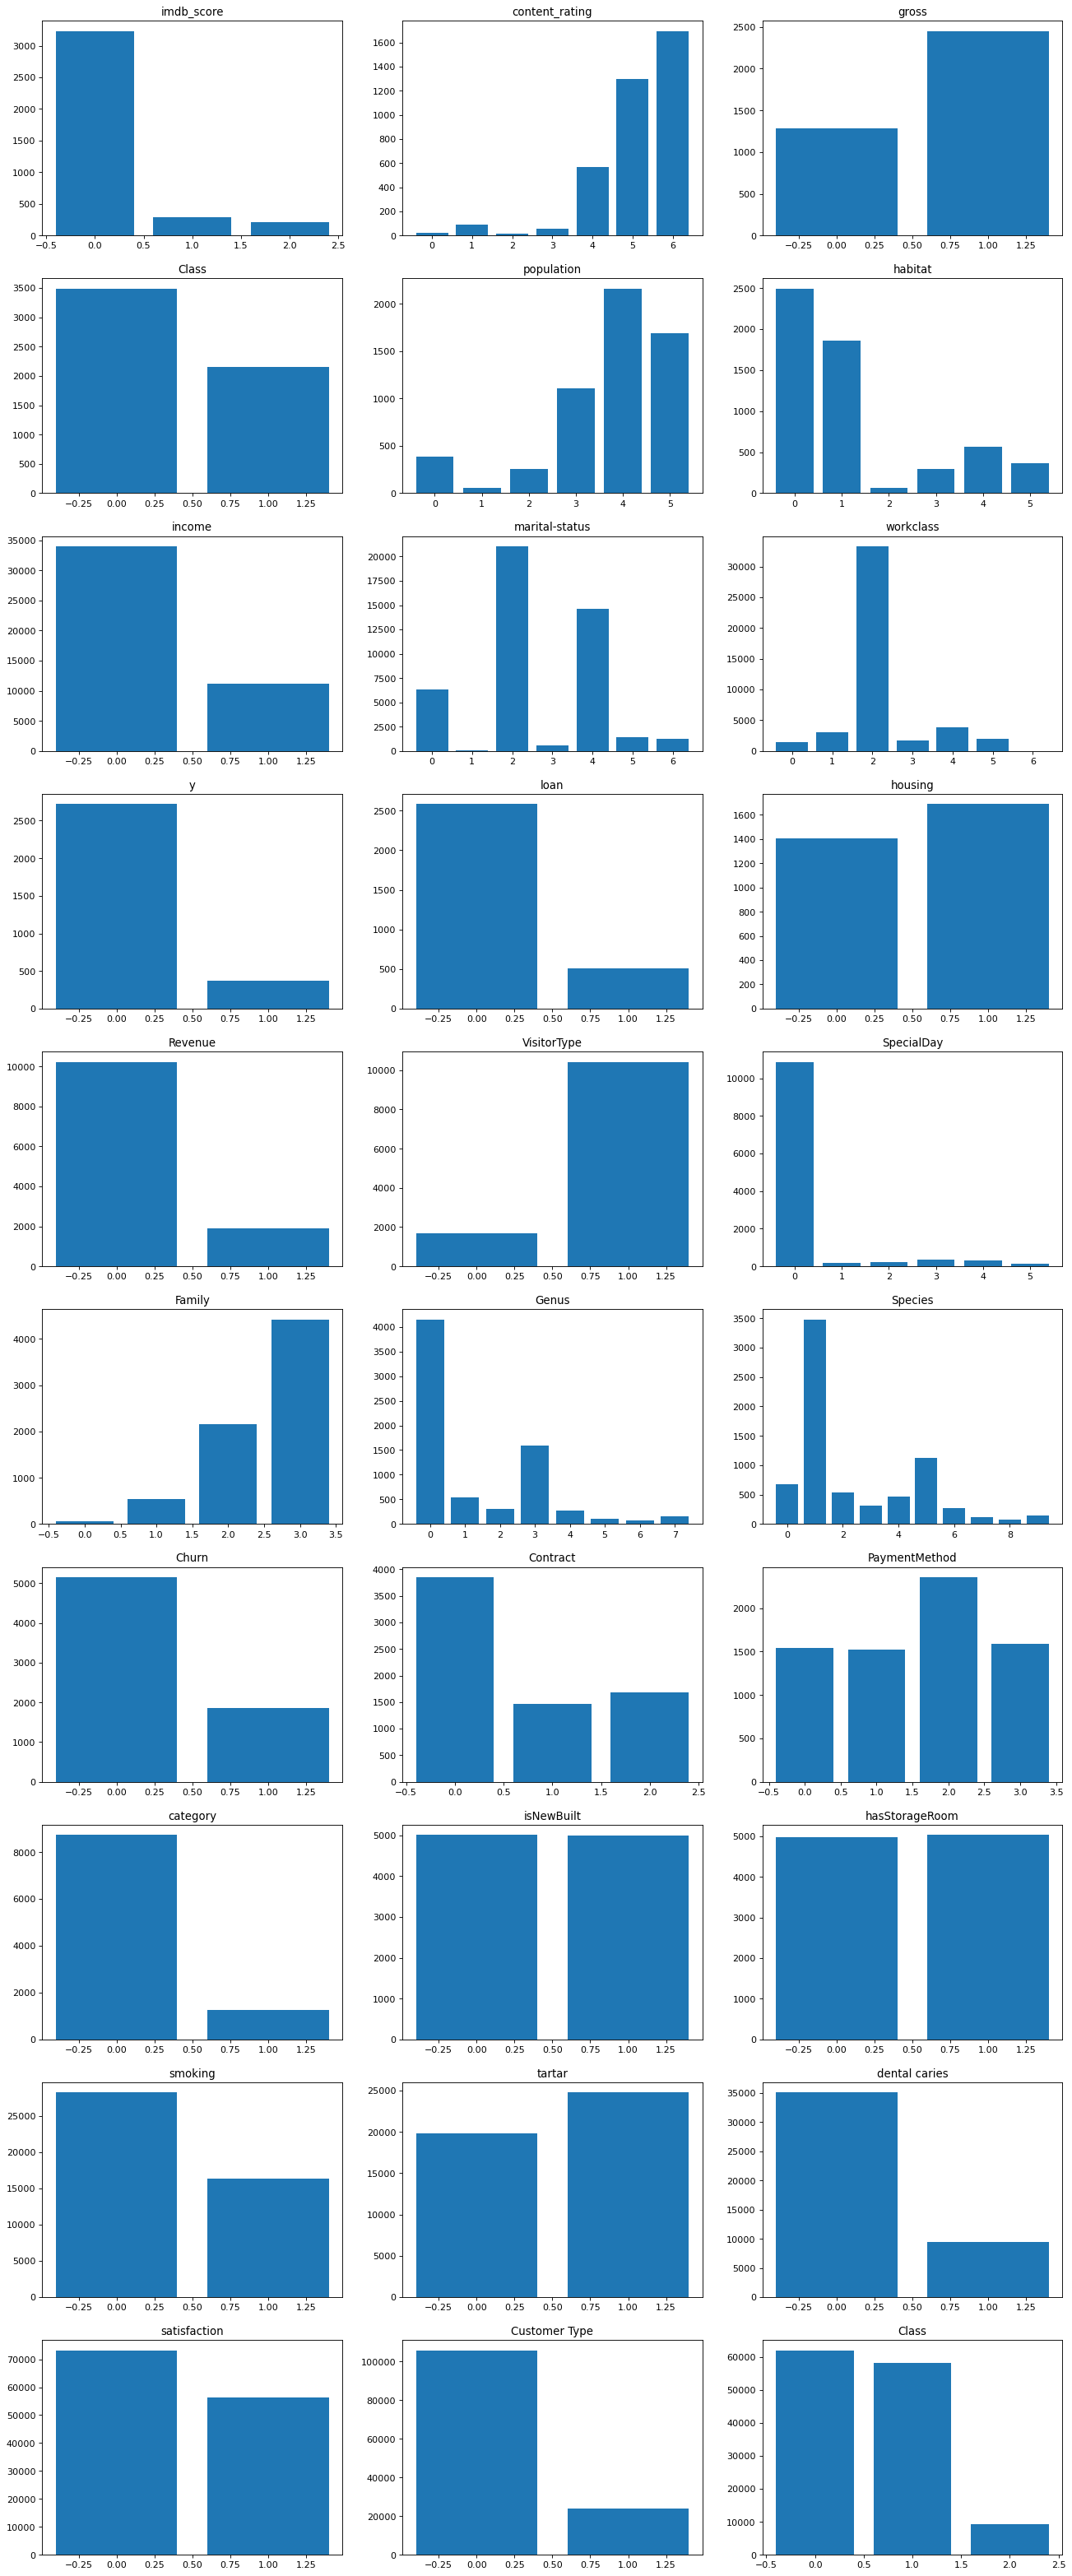

In [3]:
def plotDist(arr, title):
  values, counts = np.unique(arr, return_counts=True)
  lis = np.asarray((values, counts)).T
  x, y = zip(*lis) # unpack a list of pairs into two tuples
  # plt.plot(x, y)
  plt.bar(x,y)

  plt.title(title)
  # plt.show()

plt.figure(figsize=(20, 50), dpi=80)

for i in range(len(DATA_STRUCTURE)):
  key = DATA_KEYS[i]
  dataSet = DATA_STRUCTURE[key]
  target, t1, t2, t3 = get_data(key)
  plt.subplot(10, 3, i*3+1)
  plotDist(t1, dataSet['target1'])
  plt.subplot(10, 3, i*3+2)
  plotDist(t2, dataSet['target2'])
  plt.subplot(10,3, i*3+3)
  plotDist(t3, dataSet['target3'])
plt.show()

In [4]:
def shuffle(df, t1, t2, t3):
  df['t1'] = t1.tolist()
  df['t2'] = t2.tolist()
  df['t3'] = t3.tolist()
  # use Seed
  shuffledDf = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
  shuffledT1 = shuffledDf['t1']
  shuffledT2 = shuffledDf['t2']
  shuffledT3 = shuffledDf['t3']

  shuffledDf = shuffledDf.drop(['t1','t2','t3'], 1)
  return shuffledDf, shuffledT1, shuffledT2, shuffledT3

def split(df, t1, t2, t3, k):
  targets = np.vstack((t1, t2,t3)).T
  chunks = np.array_split(df, k)
  classes = np.array_split(targets, k)
  return chunks, classes


## BaseLine Classification


In [352]:
from numpy import average
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore') 

# Because Scikit-learn's multi output classifier doesn't support metrics for multi label classification, we implemented our own.
def crossValidate(classifier, df, t1, t2, t3, k, dataSetName):
  df, t1, t2, t3 = shuffle(df, t1, t2, t3)
  # Split the data and classes into k subsets
  data, classes = split(df, t1, t2, t3, k)
  foldResults = {
    'target1' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
      
    },
    'target3' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target2' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    }
  }

  for i in range(k):
    # use the data at position i as the test data
    testData = data[i]
    testClasses = classes[i]

    # use the data at all positions other than i as the train data
    trainData = pd.concat((data[:i] + data[i+1:]))
    trainclasses = np.concatenate((classes[:i] + classes[i+1:]))
    
    # Create a multioutput classifier from the provided classifier
    clf = MultiOutputClassifier(classifier())

    

    # Fit the model to Training data
    clf.fit(trainData, trainclasses)

    # Use the model on the test data
    testResults = clf.predict(X=testData)

    # Since the results for multi label classification come as a list of size (n, 3), decompose the list into the results for each target
    t1Results = testResults[:, 0]
    t2Results = testResults[:, 1]
    t3Results = testResults[:, 2]

    # Do the same for the actual classes
    t1Classes = testClasses[:, 0]
    t2Classes = testClasses[:, 1]
    t3Classes = testClasses[:, 2]

    actualVsPredicted = {
      'target1':(t1Classes, t1Results),
      'target2':(t2Classes, t2Results),
      'target3':(t3Classes, t3Results)
    }
    for target in actualVsPredicted:
      (actual, predicted) = actualVsPredicted[target]
      # Calculate the scores for each metric
      prec_macro = precision_score(actual, predicted, average='macro', zero_division=0)
      recall_macro = recall_score(actual, predicted, average="macro", zero_division=0)
      f1_macro = f1_score(actual, predicted, average='macro')
      geometric_mean = geometric_mean_score(actual, predicted)
      specificity = specificity_score(actual, predicted, average='macro')

      # Add the scores for the current train/test split to the list of other scores for the respective target
      foldResults[target]['precScores'].append(prec_macro)
      foldResults[target]['recallScores'].append(recall_macro)
      foldResults[target]['f1Scores'].append(f1_macro)
      foldResults[target]['geometricMeanScores'].append(geometric_mean)
      foldResults[target]['specificityScores'].append(specificity)
  

  df = pd.DataFrame(columns=OUTPUT_COLS)
  for target in foldResults:
    stats = foldResults[target]
    row = [dataSetName, target,DATA_STRUCTURE[dataSetName][target]]
    for stat in stats:
      row.append(average(stats[stat]))
      row.append(stats[stat])
    pdRow = pd.DataFrame(row).T
    pdRow.columns = OUTPUT_COLS
    df = pd.concat([df,pdRow], axis=0, ignore_index=True)
  return df

aggregateMetrics = {}

for name in CLASSIFIERS:
  print(name+ ': Starting')
  outputDf = pd.DataFrame()
  for i in range(len(DATA_STRUCTURE)):
    if i < 80:
      print('   '+ DATA_KEYS[i] + ': starting')
      df, target1, target2, target3 = get_data(DATA_KEYS[i] )
      outputDf = pd.concat([outputDf, crossValidate(CLASSIFIERS[name],df, target1, target2, target3, 5, DATA_KEYS[i])], ignore_index=True)
    # print(outputDf)
  print(name+ ': done')
  print('The average of each metric after cross validation per target across all data sets')
  result = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean','avg_specificity'].mean()
  print(result)
  aggregateMetrics[name] = result
  outputDf.to_csv(path_or_buf=f'./out/{name}.csv')
  

GaussianNB: Starting
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
GaussianNB: done
The average of each metric after cross validation per target across all data sets
         avg_precision  avg_recall    avg_f1  avg_geometric_mean  \
target                                                             
target1       0.696938    0.734007  0.681447            0.663169   
target2       0.518777    0.560339  0.491333            0.484605   
target3       0.507913    0.540713  0.485450            0.381060   

         avg_specificity  
target                    
target1         0.752575  
target2         0.745554  
target3         0.758054  
LinearDiscriminantAnalysis: Starting
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoki

In [5]:
classifierMetrics = {}

for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/{name}.csv')

  targets = ['target1', 'target2', 'target3']
  metricCols = ['target', 'metric','min','max','avg', 'error']
  allMetrics = pd.DataFrame(columns=metricCols)
  for target in targets:

    minPrecision = min(df.loc[df['target'] == target]['avg_precision'])
    maxPrecision = max(df.loc[df['target'] == target]['avg_precision'])
    avgPrecision = average((df.loc[df['target'] == target]['avg_precision']))
    # print(f'{name}: min:{minPrecision}, max:{maxPrecision}, avg: {avgPrecision}')

    prec = pd.DataFrame([target, 'precision',minPrecision, maxPrecision, avgPrecision, [abs(minPrecision-avgPrecision),abs(maxPrecision-avgPrecision)]]).T
    prec.columns = columns=metricCols

    minRecall = min(df.loc[df['target'] == target]['avg_recall'])
    maxRecall = max(df.loc[df['target'] == target]['avg_recall'])
    avgRecall = average((df.loc[df['target'] == target]['avg_recall']))
    # print(f'{name}: min:{minRecall}, max:{maxRecall}, avg: {avgRecall}')

    rec = pd.DataFrame([target, 'recall',minRecall, maxRecall, avgRecall, [abs(minRecall-avgRecall),abs(maxRecall-avgRecall)]]).T
    rec.columns = columns=metricCols

    minf1 = min(df.loc[df['target'] == target]['avg_f1'])
    maxf1 = max(df.loc[df['target'] == target]['avg_f1'])
    avgf1 = average((df.loc[df['target'] == target]['avg_f1']))
    # print(f'{name}: min:{minf1}, max:{maxf1}, avg: {avgf1}')

    f1 = pd.DataFrame([target, 'f1',minf1, maxf1, avgf1, [abs(minf1-avgf1),abs(maxf1-avgf1)]]).T
    f1.columns = columns=metricCols
    

    minGeometricMean = min(df.loc[df['target'] == target]['avg_geometric_mean'])
    maxGeometricMean = max(df.loc[df['target'] == target]['avg_geometric_mean'])
    avgGeometricMean = average((df.loc[df['target'] == target]['avg_geometric_mean']))
    # print(f'{name}: min:{minGeometricMean}, max:{maxGeometricMean}, avg: {avgGeometricMean}')

    gMean = pd.DataFrame([target, 'geometric mean',minGeometricMean, maxGeometricMean, avgGeometricMean, [abs(minGeometricMean-avgGeometricMean),abs(maxGeometricMean-avgGeometricMean)]]).T
    gMean.columns = columns=metricCols
    

    minSpecificity = min(df.loc[df['target'] == target]['avg_specificity'])
    maxSpecificity = max(df.loc[df['target'] == target]['avg_specificity'])
    avgSpecificity = average((df.loc[df['target'] == target]['avg_specificity']))
    # print(f'{name}: min:{minSpecificity}, max:{maxSpecificity}, avg: {avgSpecificity}')

    spec = pd.DataFrame([target, 'specificity',minSpecificity, maxSpecificity, avgSpecificity, [abs(minSpecificity-avgSpecificity),abs(maxSpecificity-avgSpecificity)]]).T
    spec.columns = columns=metricCols

    allMetrics = pd.concat([allMetrics, prec, rec, f1, gMean, spec], axis=0, ignore_index=True)

  classifierMetrics[name] = allMetrics

for name in classifierMetrics:
  print(f'----[{name}]----')
  print(classifierMetrics[name])

# for stat in stats:
#   row.append(average(stats[stat]))
#   row.append(stats[stat])
# pdRow = pd.DataFrame(row).T
# pdRow.columns = OUTPUT_COLS
# df = pd.concat([df,pdRow], axis=0, ignore_index=True)


----[GaussianNB]----
     target          metric       min       max       avg  \
0   target1       precision   0.43675  0.994964  0.696938   
1   target1          recall       0.5   0.99644  0.734007   
2   target1              f1   0.43823  0.995687  0.681447   
3   target1  geometric mean       0.0  0.996437  0.663169   
4   target1     specificity       0.5   0.99644  0.752575   
5   target2       precision  0.137593  0.755864  0.518777   
6   target2          recall  0.235874  0.842081  0.560339   
7   target2              f1  0.110366  0.782982  0.491333   
8   target2  geometric mean       0.0  0.842047  0.484605   
9   target2     specificity  0.475056  0.976884  0.745554   
10  target3       precision  0.170194  0.821853  0.507913   
11  target3          recall  0.177116  0.843944  0.540713   
12  target3              f1  0.146381  0.810947   0.48545   
13  target3  geometric mean       0.0  0.808918   0.38106   
14  target3     specificity  0.505238  0.990067  0.758054   

  

In [372]:
print(classifierMetrics['DecisionTreeClassifier'])

     target          metric       min       max       avg  \
0   target1       precision   0.58779       1.0  0.759363   
1   target1          recall  0.591954       1.0  0.763339   
2   target1              f1  0.588651       1.0   0.76088   
3   target1  geometric mean  0.516761       1.0  0.742575   
4   target1     specificity  0.650065       1.0  0.789388   
5   target2       precision  0.302908  0.948743  0.572664   
6   target2          recall  0.315822  0.951044  0.571912   
7   target2              f1  0.308239  0.949883  0.570854   
8   target2  geometric mean       0.0  0.950573  0.478692   
9   target2     specificity   0.49613   0.99056  0.761358   
10  target3       precision  0.219644  0.854415  0.503329   
11  target3          recall  0.224515   0.85589  0.504885   
12  target3              f1  0.221753  0.852233  0.503086   
13  target3  geometric mean       0.0  0.843941  0.417366   
14  target3     specificity  0.502859  0.993052  0.759893   

                       

In [9]:
# New Graph

# plt.figure(figsize=(30, 30), dpi=90)
learners = list(aggregateMetrics.keys())
for i in range(len(learners)):

  learner = learners[i]

  metrics = ['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean', 'avg_specificity']
  t1Avg= classifierMetrics[learner].loc[[0, 1, 2, 3, 4],['avg']].values
  t1Min = classifierMetrics[learner].loc[[0, 1, 2, 3, 4],['min']].values
  t1Max = classifierMetrics[learner].loc[[0, 1, 2, 3, 4],['max']].values
  # t1Err = classifierMetrics[learner].loc[[0, 1, 2, 3, 4],['error']].values
  # t1Adjusted = aggregateMetricsAdjusted[learner].iloc[0].values
  t2Avg= classifierMetrics[learner].loc[[5, 6, 7, 8, 9], ['avg']].values
  t2Min= classifierMetrics[learner].loc[[5, 6, 7, 8, 9], ['min']].values
  t2Max= classifierMetrics[learner].loc[[5, 6, 7, 8, 9], ['max']].values
  # t2Adjusted = aggregateMetricsAdjusted[learner].iloc[1].values
  t3Avg= classifierMetrics[learner].loc[[10, 11, 12, 13, 14],['avg']].values
  t3Min= classifierMetrics[learner].loc[[10, 11, 12, 13, 14],['min']].values
  t3Max= classifierMetrics[learner].loc[[10, 11, 12, 13, 14],['max']].values
  # t3Adjusted = aggregateMetricsAdjusted[learner].iloc[2].values
  # ax = plt.subplot(len(learners),3, i*3+1)
  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=16)
  fig.set_figwidth(30)
  fig.set_figheight(5)
  axs[0].set(xmargin= 0.2, ylim=(0, 1))
  # print(t1.shape)
  axs[0].errorbar(metrics, t1Avg, fmt='bo', linewidth=2, capsize=6)
  # axs[0].errorbar(metrics, t1Min, fmt='bo', linewidth=2, capsize=6)
  # axs[0].errorbar(metrics, t1Max, fmt='bo', linewidth=2, capsize=6)
  # ax.errorbar(metrics, t1, fmt='bo', linewidth=2, capsize=6)
  # ax.errorbar(metrics, t1Adjusted, fmt='ro', linewidth=2, capsize=6)

  plt.title('Target1')

  axs[1].set(xmargin= 0.2, ylim=(0, 1))
  axs[1].errorbar(metrics, t2Avg, fmt='bo', linewidth=2, capsize=6)
  # axs[1].errorbar(metrics, t2Min, fmt='bo', linewidth=2, capsize=6)
  # axs[1].errorbar(metrics, t2Max, fmt='bo', linewidth=2, capsize=6)
  # ax.errorbar(metrics, t2Adjusted, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target2')

  axs[2].set(xmargin= 0.2, ylim=(0, 1))
  axs[2].errorbar(metrics, t3Avg, fmt='bo', linewidth=2, capsize=6)
  # axs[2].errorbar(metrics, t3Min, fmt='bo', linewidth=2, capsize=6)
  # axs[2].errorbar(metrics, t3Max, fmt='bo', linewidth=2, capsize=6)
  # ax.errorbar(metrics, t3Adjusted, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target3')

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)  
plt.show()

# print('-------------------------------')

<Figure size 640x480 with 0 Axes>

## Addressing Imbalance using Oversampling


In [405]:
# Only on train
# Naive Approach: Look at target variable that is performing worst, try to do something about that variable only
# Generate features, but also other target values - Add other targets as features.. Make sure to remove them before training
# Use modified data to train 

# imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler

plt.figure(figsize=(20, 50), dpi=80)
def crossValidateSmote(classifier, df, t1, t2, t3, k, dataSetName):
  df, t1, t2, t3 = shuffle(df, t1, t2, t3)
  # Split the data and classes into k subsets
  data, classes = split(df, t1, t2, t3, k)
  foldResults = {
    'target1' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target3' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target2' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    }
  }
  for i in range(k):
    # use the data at position i as the test data
    testData = data[i]
    testClasses = classes[i]

    # use the data at all positions other than i as the train data
    trainData = pd.concat((data[:i] + data[i+1:]))
    trainClasses = np.concatenate((classes[:i] + classes[i+1:]))

    t1Class = trainClasses[:, 0]
    t2Class = trainClasses[:, 1]
    t3Class = trainClasses[:, 2]

    # Apply SMOTE to the training data
    testDataCombined = combine(trainData, t1Class, t2Class, t3Class).drop(['t1'], 1)

    sm = SMOTE(random_state=SEED, sampling_strategy='not majority')
    us = RandomUnderSampler(random_state=SEED)
    # sm = CondensedNearestNeighbour(random_state=SEED)
    # sm = RandomOverSampler(random_state=SEED, sampling_strategy=0.5)
    # sm = RandomOverSampler(random_state=SEED, sampling_strategy='not majority')

    reSampled_df, resampled_target1 = sm.fit_resample(testDataCombined, t1Class)
    reSampled_df, resampled_target1 = us.fit_resample(reSampled_df, resampled_target1)
    resampled_target2 = reSampled_df['t2']
    resampled_target3 = reSampled_df['t3']
    reSampled_df = reSampled_df.drop(['t2','t3'], 1)

    # plt.subplot(10, 2, i*2+1)
    # plotDist(t1, f'{dataSetName}: cross{i}: Old Distribution')
    # plt.subplot(10, 2, i*2+2)
    # plotDist(resampled_target1,  f'{dataSetName}: cross{i}: New Distribution')

    # Build the training outpus classes using the resampled target1 values (generated as classes), and the target2 and target3 values (generated as features) from smote 
    resampledTrainClasses = np.vstack((resampled_target1, resampled_target2,resampled_target3)).T
  
    # Create a multioutput classifier from the provided classifier
    clf = MultiOutputClassifier(classifier())

    # Fit the model to Training data
    clf.fit(reSampled_df, resampledTrainClasses)

    # Use the model on the test data
    testResults = clf.predict(X=testData)
    # Since the results for multi label classification come as a list of size (n, 3), decompose the list into the results for each target
    t1Results = testResults[:, 0]
    t2Results = testResults[:, 1]
    t3Results = testResults[:, 2]

    # Do the same for the actual classes
    t1Classes = testClasses[:, 0]
    t2Classes = testClasses[:, 1]
    t3Classes = testClasses[:, 2]

    actualVsPredicted = {
      'target1':(t1Classes, t1Results),
      'target2':(t2Classes, t2Results),
      'target3':(t3Classes, t3Results)
    }
    for target in actualVsPredicted:
      (actual, predicted) = actualVsPredicted[target]
      # Calculate the scores for each metric
      prec_macro = precision_score(actual, predicted, average='macro', zero_division=0)
      recall_macro = recall_score(actual, predicted, average="macro", zero_division=0)
      f1_macro = f1_score(actual, predicted, average='macro')
      geometric_mean = geometric_mean_score(actual, predicted)
      specificity = specificity_score(actual, predicted, average='macro')
      # Geometric means

      # Add the scores for the current train/test split to the list of other scores for the respective target

      # 3 targets

      # Add the scores for the current train/test split to the list of other scores for the respective target
      foldResults[target]['precScores'].append(prec_macro)
      foldResults[target]['recallScores'].append(recall_macro)
      foldResults[target]['f1Scores'].append(f1_macro)
      foldResults[target]['geometricMeanScores'].append(geometric_mean)
      foldResults[target]['specificityScores'].append(specificity)

      # 'avg_specificity','specificity_folds'

  df = pd.DataFrame(columns=OUTPUT_COLS)
  # print(len(OUTPUT_COLS))
  for target in foldResults:
    stats = foldResults[target]
    row = [dataSetName,target, DATA_STRUCTURE[dataSetName][target]]
    for stat in stats:
      row.append(average(stats[stat]))
      row.append(stats[stat])
    pdRow = pd.DataFrame(row).T
    pdRow.columns = OUTPUT_COLS
    df = pd.concat([df,pdRow], axis=0, ignore_index=True)
  # print(df)
  return df

def combine(df, t1, t2,t3):
  df['t1'] = t1.tolist()
  df['t2'] = t2.tolist()
  df['t3'] = t3.tolist()
  return df


aggregateMetricsAdjusted = {}
for name in CLASSIFIERS:
  print(name+ ': Starting')
  outputDf = pd.DataFrame()
  print(len(DATA_STRUCTURE))
  for i in range(len(DATA_STRUCTURE)):
    print('   '+ DATA_KEYS[i] + ': starting')
    df, target1, target2, target3 = get_data(DATA_KEYS[i])
    outputDf = pd.concat([outputDf, crossValidateSmote(CLASSIFIERS[name],df, target1, target2, target3, 5, DATA_KEYS[i])], ignore_index=True)
    # print(outputDf)
    
  print(name+ ': done')
  print('The average of each metric after cross validation per target across all data sets')
  result = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean', 'avg_specificity'].mean()
  aggregateMetricsAdjusted[name] = result
  outputDf.to_csv(path_or_buf=f'./out/balanced/{name}.csv')

GaussianNB: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
GaussianNB: done
The average of each metric after cross validation per target across all data sets
LinearDiscriminantAnalysis: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
LinearDiscriminantAnalysis: done
The average of each metric after cross validation per target across all data sets
KNeighborsClassifier: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
KNeighborsClassifier: done
The average of each metric after cross validation per target 

<Figure size 1600x4000 with 0 Axes>

In [10]:
aggregateMetrics = {}
aggregateStandardDev = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/{name}.csv')
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean'].mean()

  standardDev = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].std()
  
  aggregateStandardDev[name] = standardDev

  aggregateMetrics[name] = result

/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/350645124.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean'].mean()
/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/350645124.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  standardDev = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].std()
/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/350645124.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean'].mean()
/var/folders/v

In [11]:
aggregateMetricsAdjusted = {}
aggregateStandardDevAdjusted = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced/{name}.csv')
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].mean()
  adjustedStandardDev = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].std()

  aggregateMetricsAdjusted[name] = result
  aggregateStandardDevAdjusted[name] = adjustedStandardDev


/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/1380860579.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].mean()
/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/1380860579.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adjustedStandardDev = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].std()
/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/1380860579.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  result = df.groupby('target')['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',].mean()
/

/var/folders/vr/tj66x9ms1wb2f6_bs8hzmt7c0000gn/T/ipykernel_87515/4267252926.py:46: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.0,


<Figure size 2500x2500 with 0 Axes>

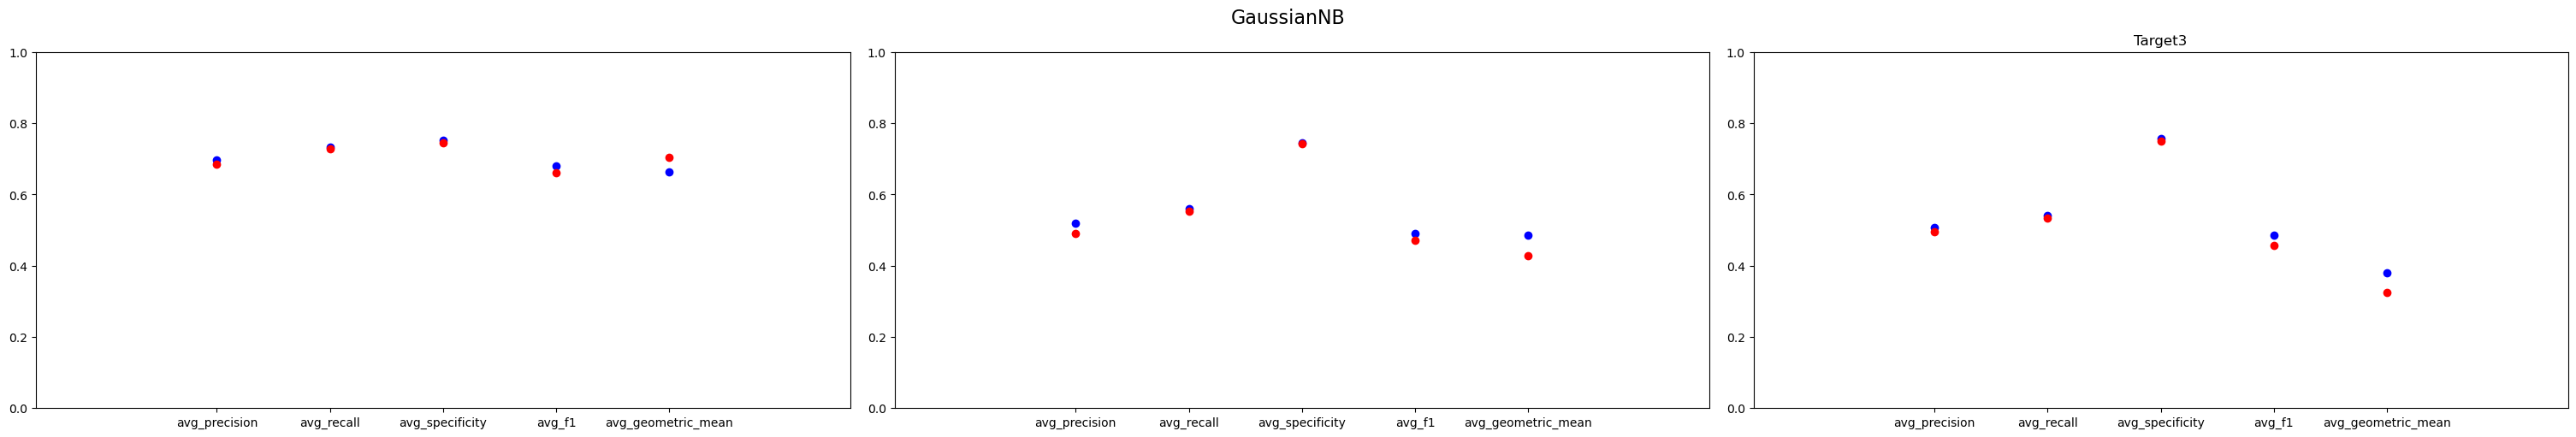

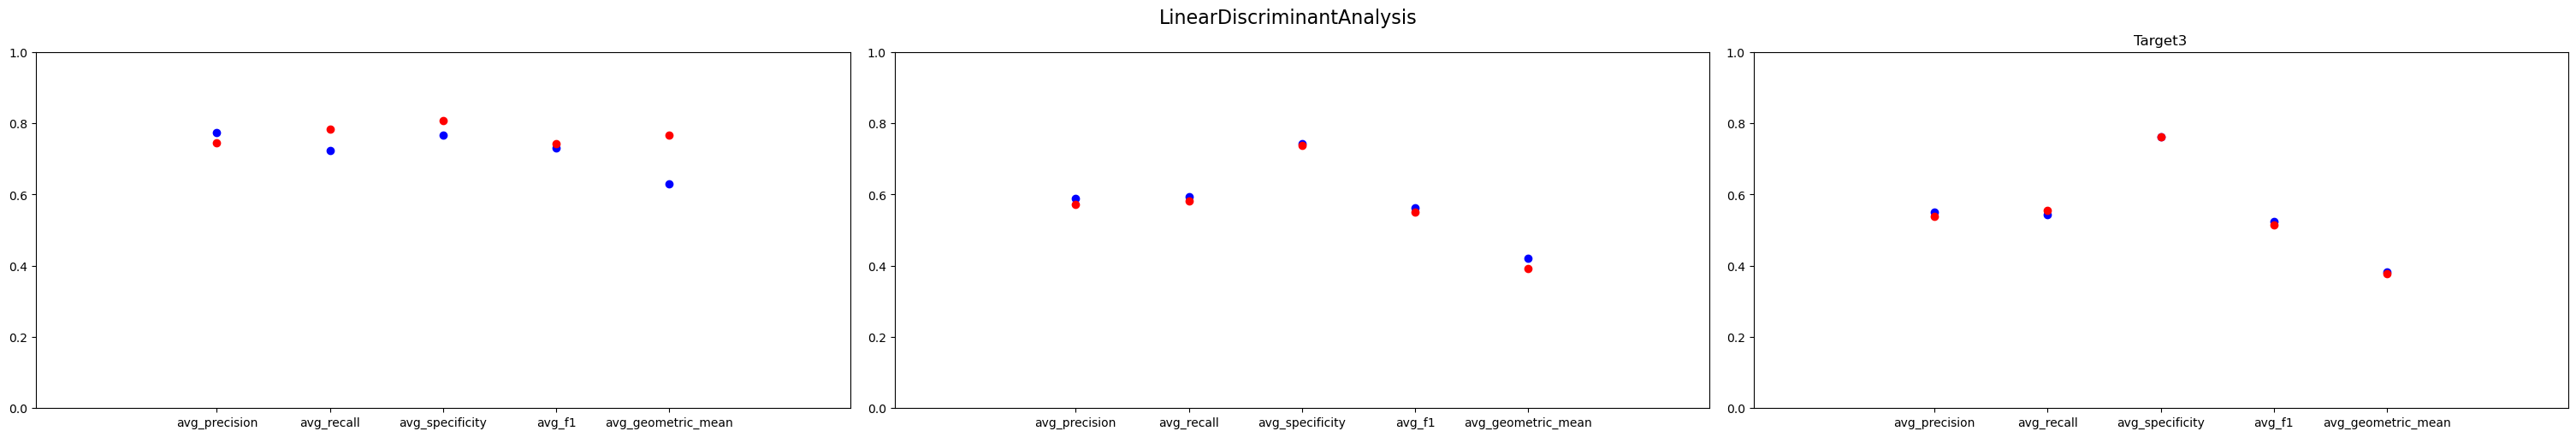

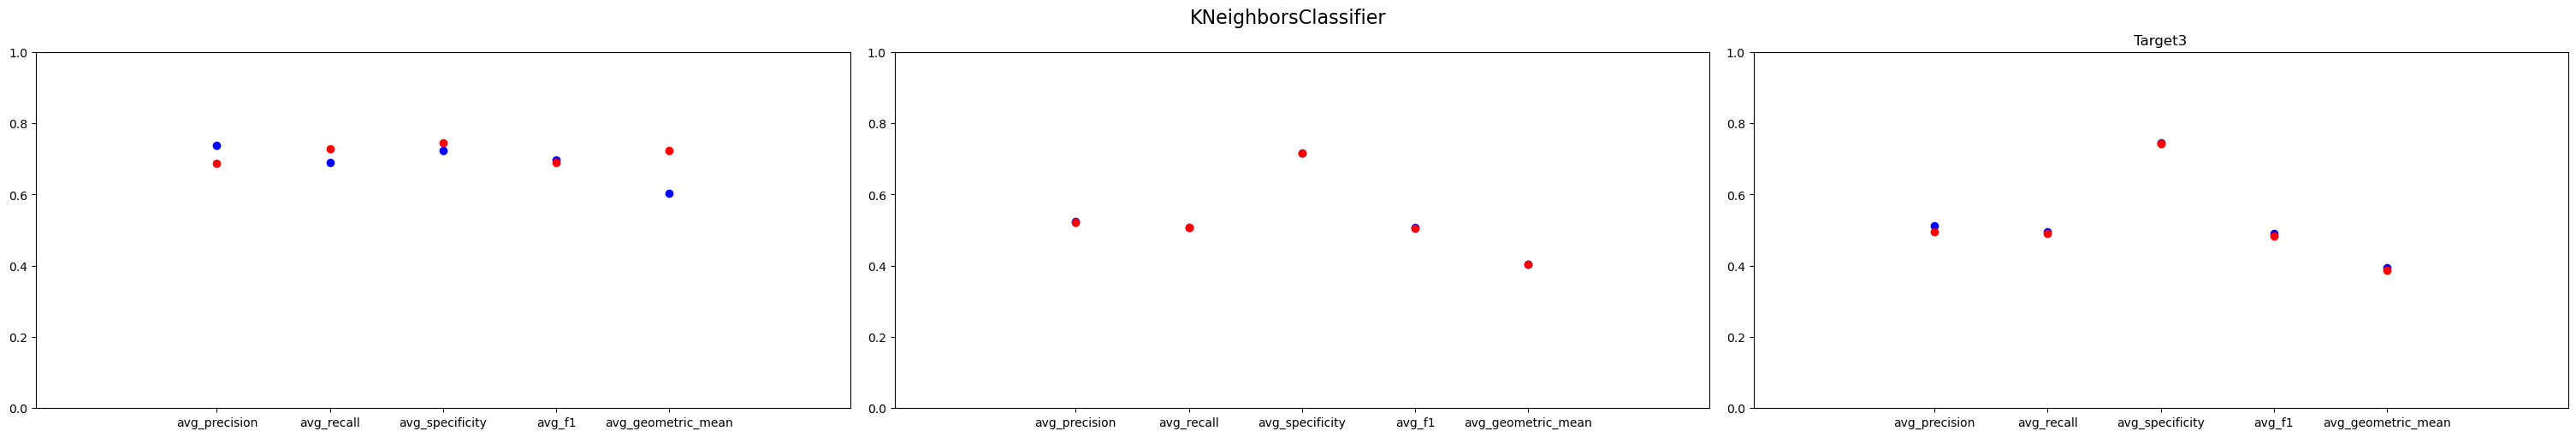

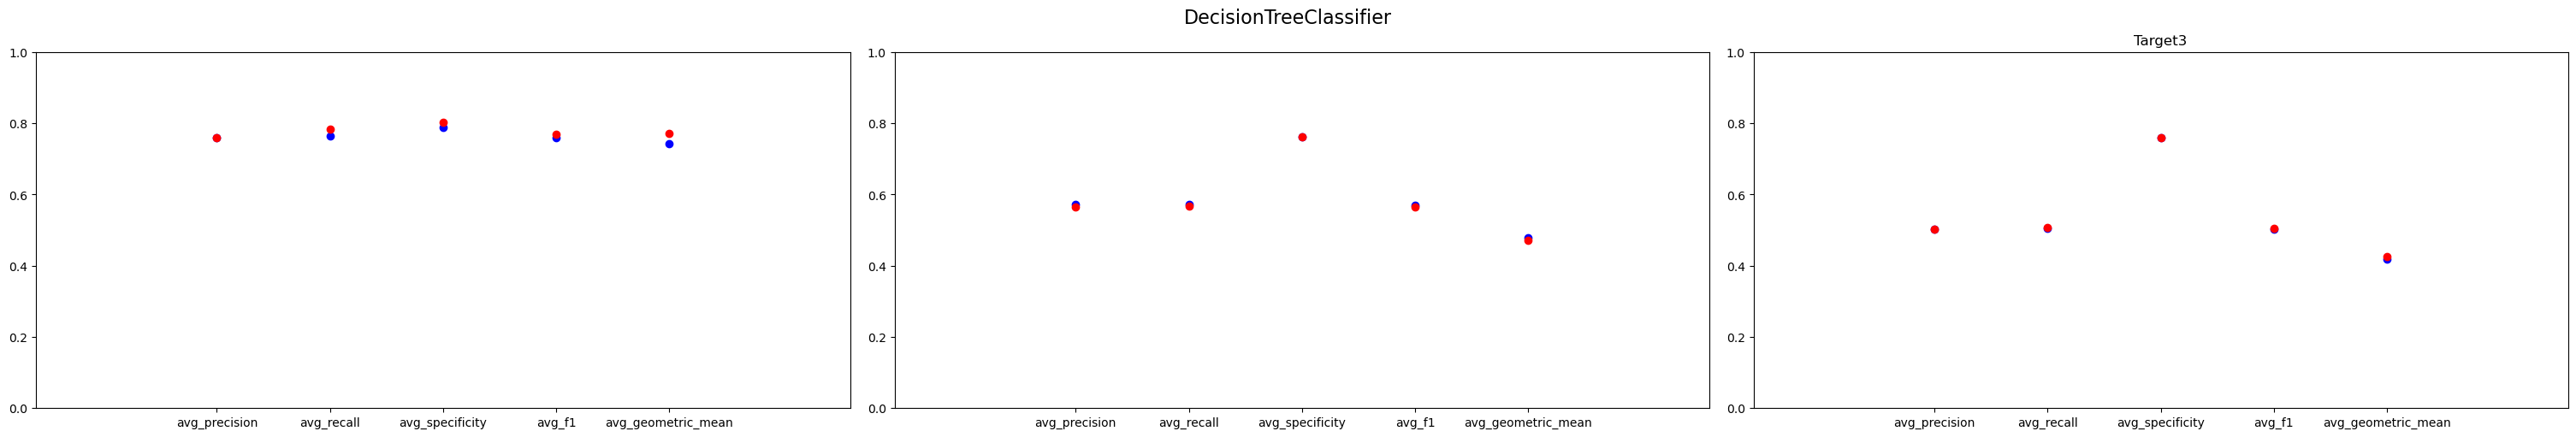

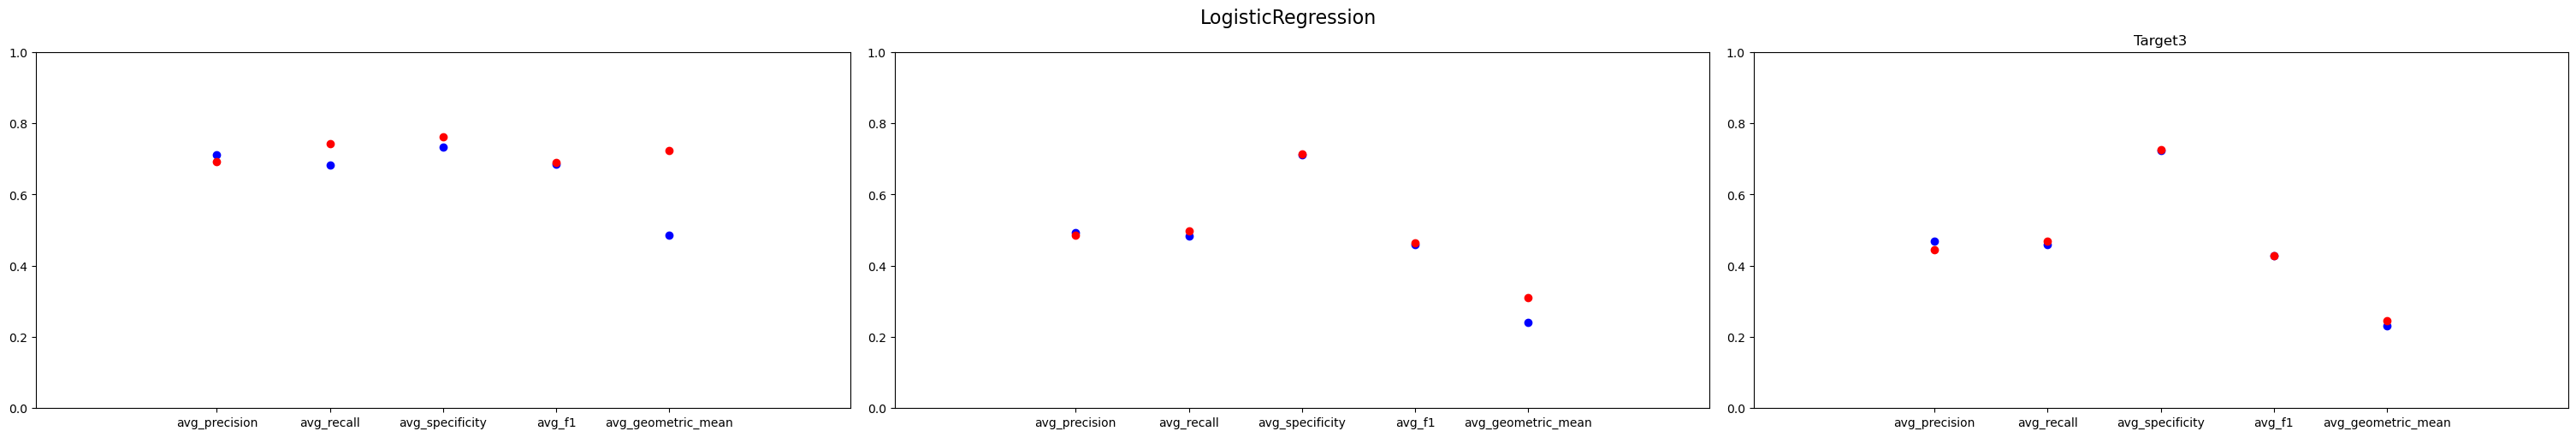

In [12]:
plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for i in range(len(learners)):
  learner = learners[i]
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  t1= aggregateMetrics[learner].iloc[0].values
  t1StandardDev = aggregateStandardDev[learner].iloc[0].values

  t1Adjusted = aggregateMetricsAdjusted[learner].iloc[0].values
  t1AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[0].values

  t2= aggregateMetrics[learner].iloc[1].values
  t2Adjusted = aggregateMetricsAdjusted[learner].iloc[1].values

  t2StandardDev = aggregateStandardDev[learner].iloc[1].values
  t2AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[1].values

  t3= aggregateMetrics[learner].iloc[2].values
  t3Adjusted = aggregateMetricsAdjusted[learner].iloc[2].values

  t3StandardDev = aggregateStandardDev[learner].iloc[2].values
  t3AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[2].values

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=16)
  fig.set_figwidth(30)
  fig.set_figheight(5)
  axs[0].set(xmargin= 0.4, ylim=(0, 1))
  axs[0].errorbar(metrics, t1, fmt='bo', linewidth=2, capsize=6)
  axs[0].errorbar(metrics, t1Adjusted ,fmt='ro', linewidth=2, capsize=6)

  plt.title('Target1')

  axs[1].set(xmargin= 0.4, ylim=(0, 1))
  axs[1].errorbar(metrics, t2, fmt='bo', linewidth=2, capsize=6)
  axs[1].errorbar(metrics, t2Adjusted, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target2')

  axs[2].set(xmargin= 0.4, ylim=(0, 1))
  axs[2].errorbar(metrics, t3, fmt='bo', linewidth=2, capsize=6)
  axs[2].errorbar(metrics, t3Adjusted, fmt='ro', linewidth=2, capsize=6)

  plt.title('Target3')

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)  
plt.show()

# print('-------------------------------')

5 5 5
5 5 5
5 5 5
5 5 5
5 5 5


<Figure size 2500x2500 with 0 Axes>

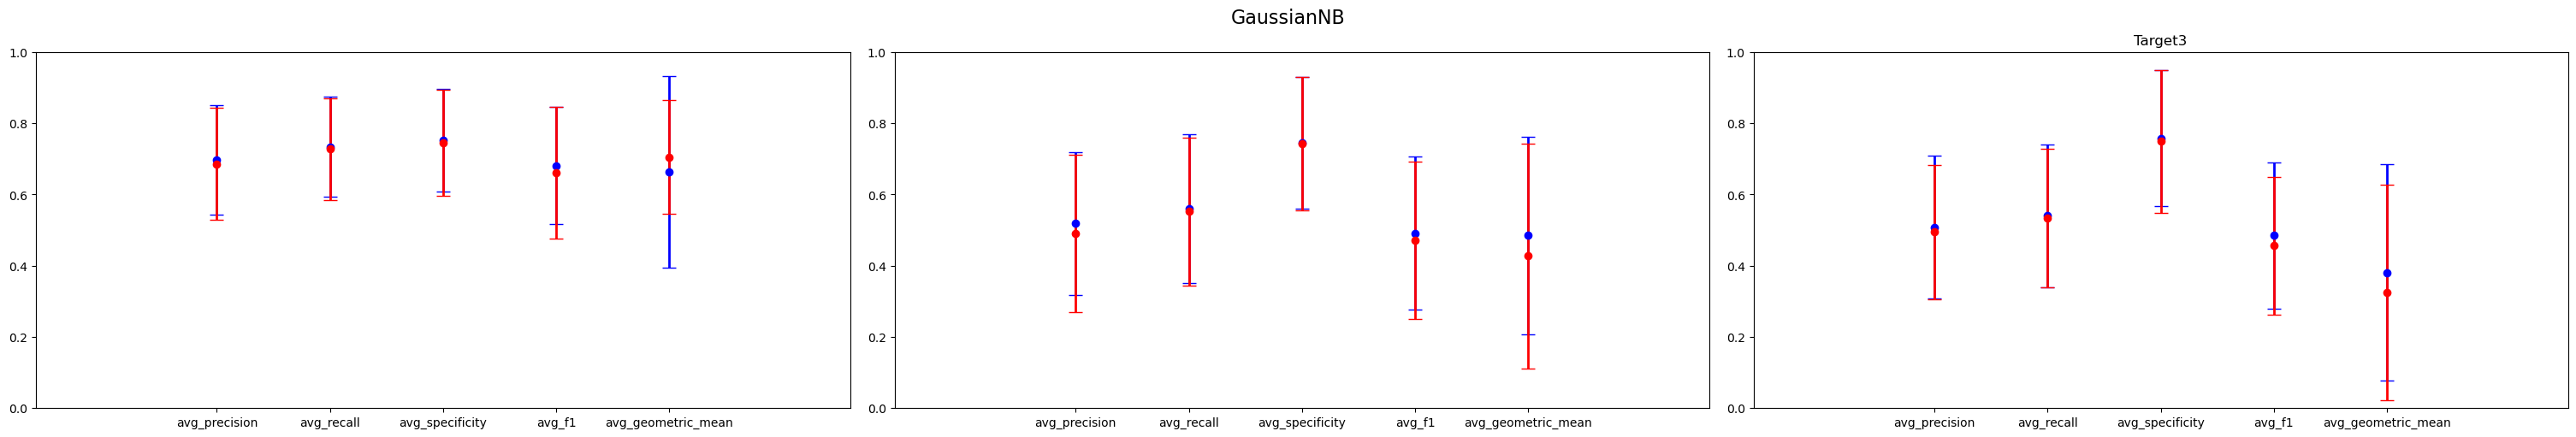

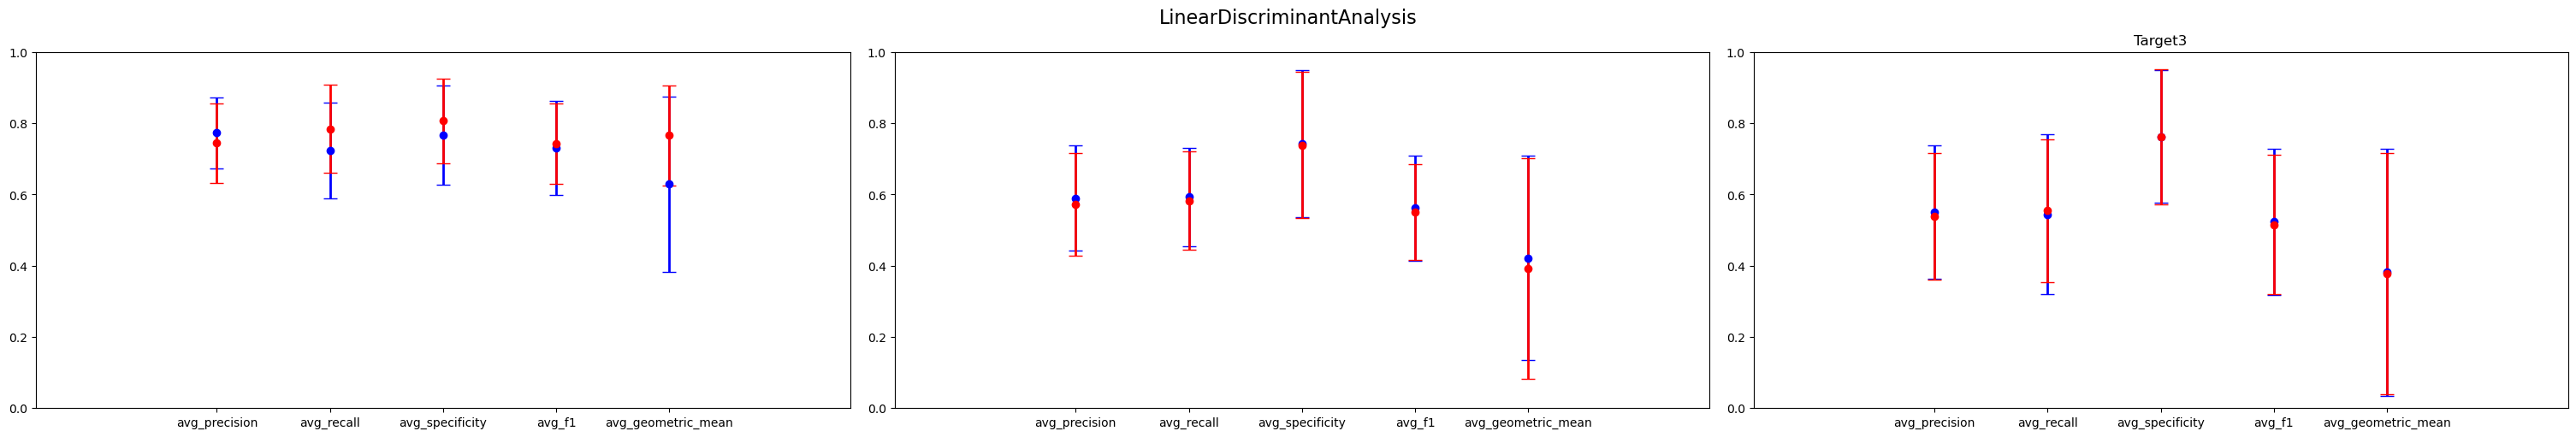

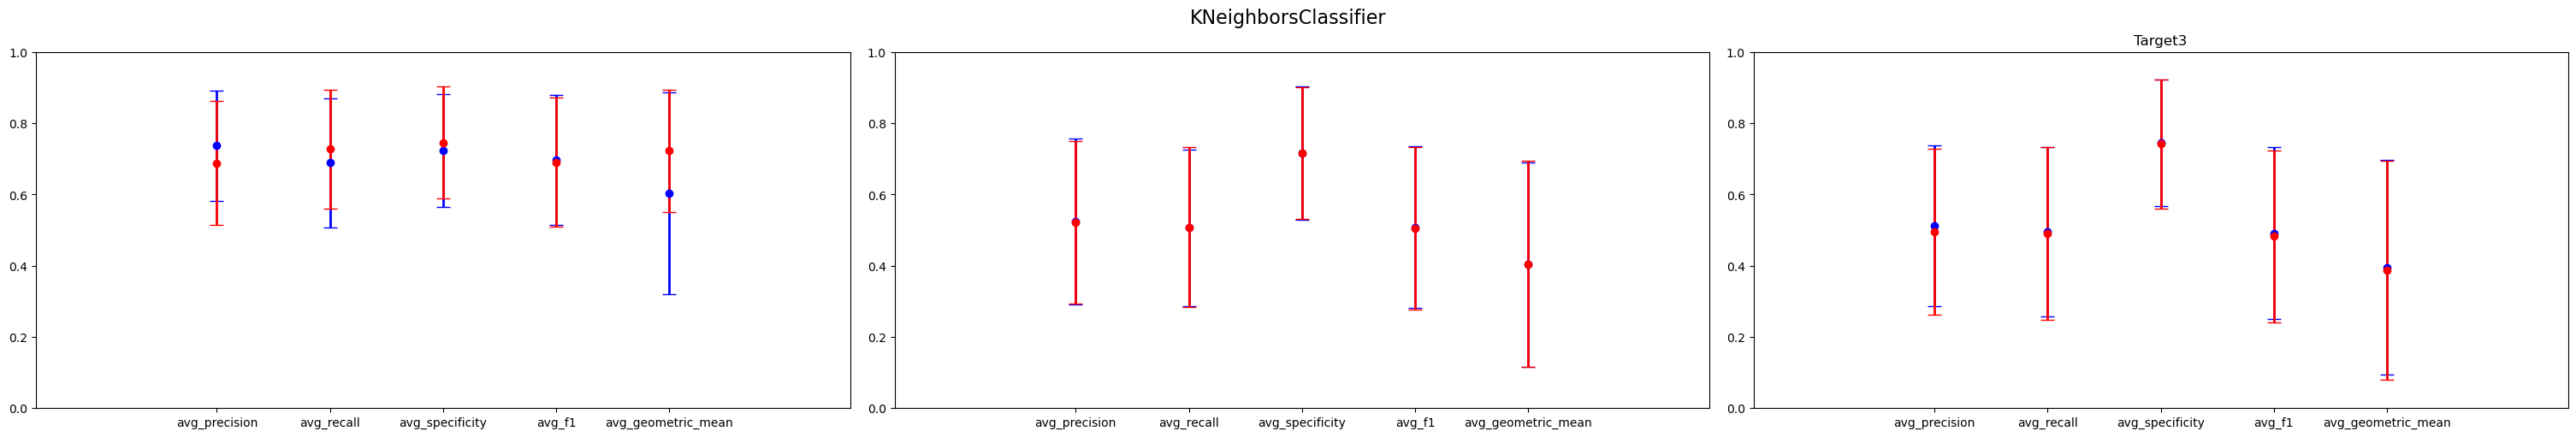

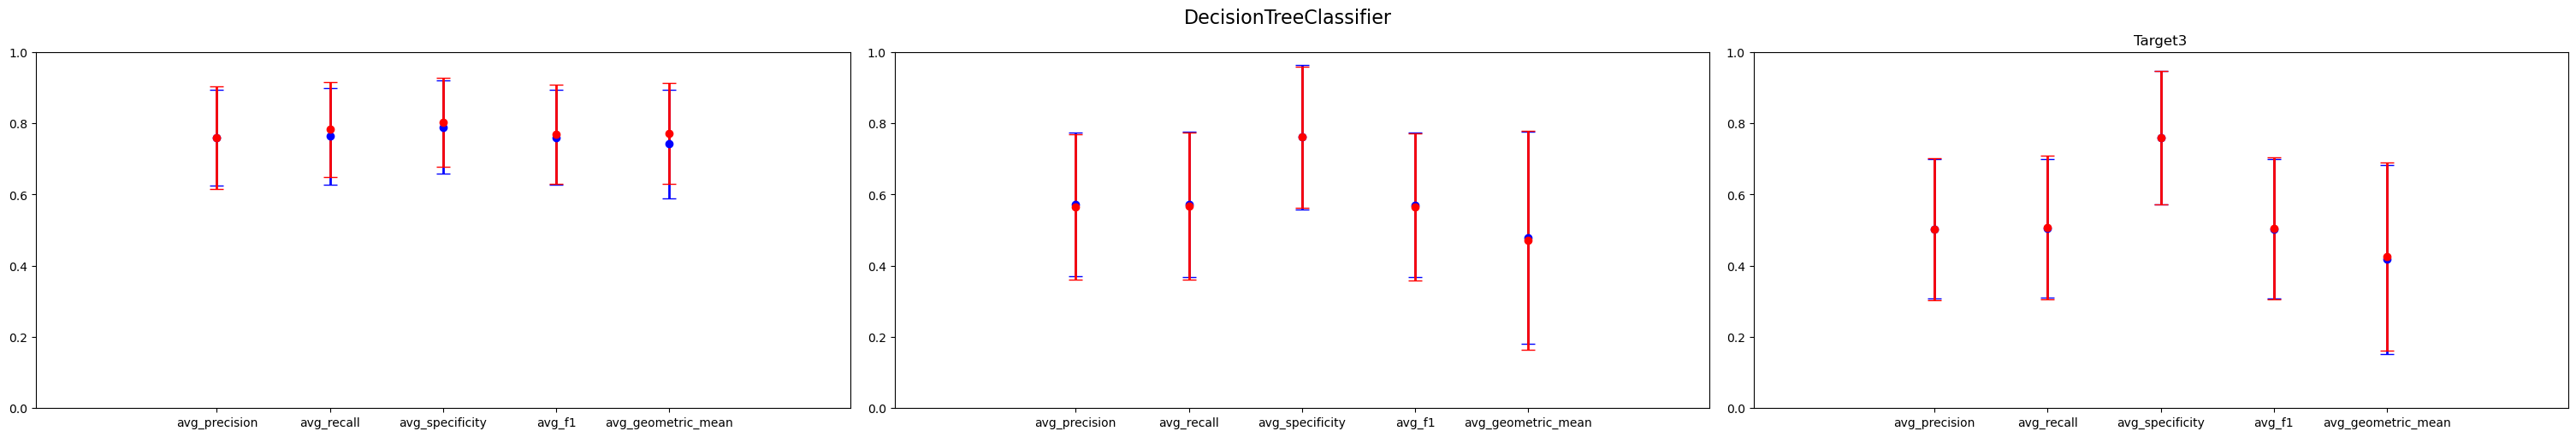

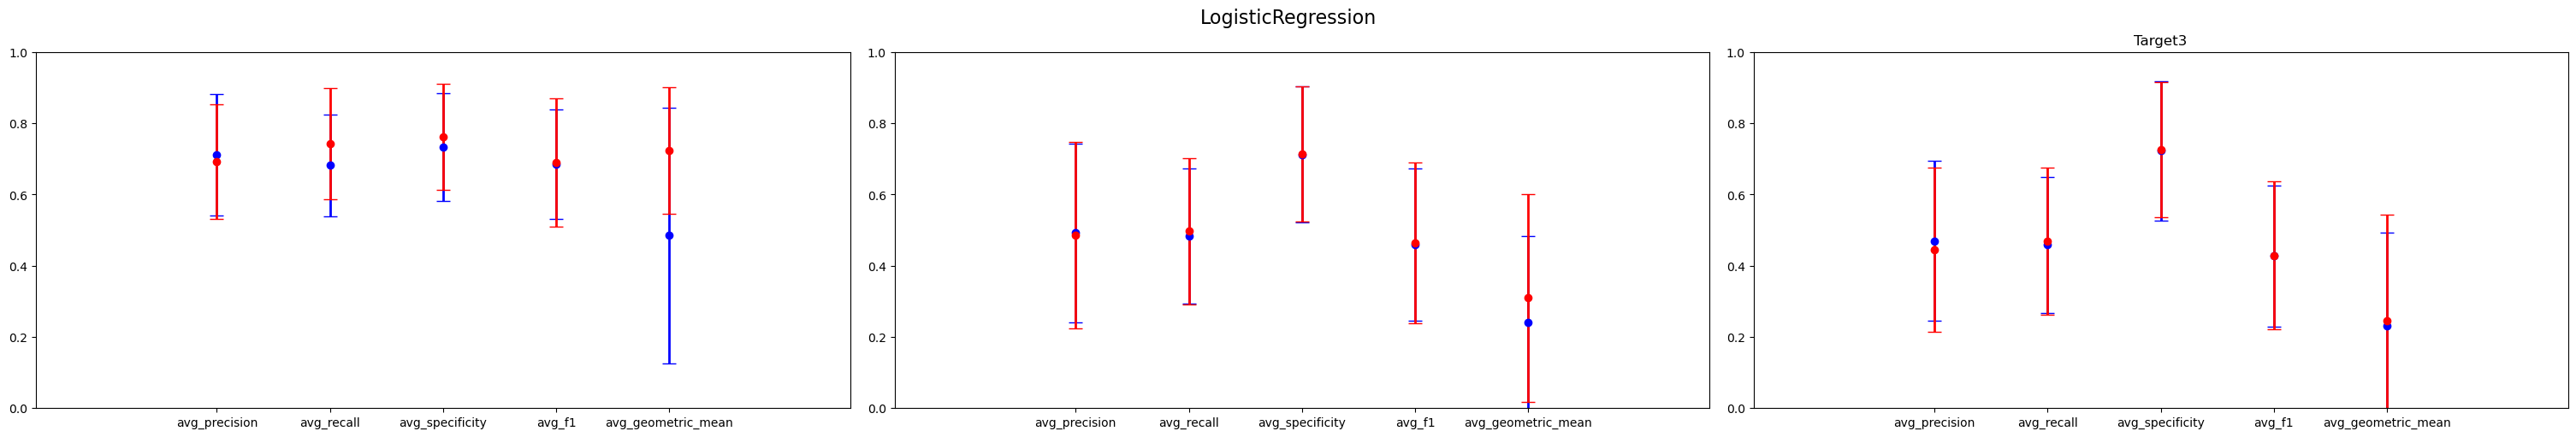

In [48]:
plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for i in range(len(learners)):
  learner = learners[i]
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  t1= aggregateMetrics[learner].iloc[0].values
  t1StandardDev = aggregateStandardDev[learner].iloc[0].values

  t1Adjusted = aggregateMetricsAdjusted[learner].iloc[0].values
  t1AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[0].values

  t2= aggregateMetrics[learner].iloc[1].values
  t2Adjusted = aggregateMetricsAdjusted[learner].iloc[1].values

  t2StandardDev = aggregateStandardDev[learner].iloc[1].values
  t2AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[1].values

  t3= aggregateMetrics[learner].iloc[2].values
  t3Adjusted = aggregateMetricsAdjusted[learner].iloc[2].values

  t3StandardDev = aggregateStandardDev[learner].iloc[2].values
  t3AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[2].values

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=16)
  fig.set_figwidth(30)
  fig.set_figheight(5)
  print(len(metrics), len(t1), len(t1Adjusted))
  axs[0].set(xmargin= 0.4, ylim=(0, 1))
  axs[0].errorbar(metrics, t1, yerr=t1StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[0].errorbar(metrics, t1Adjusted, yerr=t1AdjustedStandardDev ,fmt='ro', linewidth=2, capsize=6)

  plt.title('Target1')

  axs[1].set(xmargin= 0.4, ylim=(0, 1))
  axs[1].errorbar(metrics, t2, yerr=t2StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[1].errorbar(metrics, t2Adjusted, yerr=t2AdjustedStandardDev, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target2')

  axs[2].set(xmargin= 0.4, ylim=(0, 1))
  axs[2].errorbar(metrics, t3, yerr=t3StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[2].errorbar(metrics, t3Adjusted, yerr=t3AdjustedStandardDev, fmt='ro', linewidth=2, capsize=6)

  plt.title('Target3')

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)  
plt.show()

# print('-------------------------------')

In [1]:
df,t1,t2,t3 = get_data('mushroom')
df['t1'] = t1.tolist()
df['t2'] = t2.tolist()
df['t3'] = t3.tolist()

df.corr().to_csv(path_or_buf=f'./out/mushroom_correlation.csv')

NameError: name 'get_data' is not defined

### Addressing Oversampling by applying Smote 3 times, once with each target as the class

In [32]:
# Only on train
# Naive Approach: Look at target variable that is performing worst, try to do something about that variable only
# Generate features, but also other target values - Add other targets as features.. Make sure to remove them before training
# Use modified data to train 

# imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler

import warnings
warnings.filterwarnings('ignore') 

plt.figure(figsize=(20, 50), dpi=80)
def crossValidateSmote(classifier, df, t1, t2, t3, k, dataSetName):
  df, t1, t2, t3 = shuffle(df, t1, t2, t3)
  # Split the data and classes into k subsets
  data, classes = split(df, t1, t2, t3, k)
  foldResults = {
    'target1' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target3' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    },
    'target2' : {
      'precScores': [],
      'recallScores': [],
      'f1Scores': [],
      'geometricMeanScores': [],
      'specificityScores': []
    }
  }
  for i in range(k):
    # use the data at position i as the test data
    testData = data[i]
    testClasses = classes[i]

    # use the data at all positions other than i as the train data
    trainData = pd.concat((data[:i] + data[i+1:]))
    trainClasses = np.concatenate((classes[:i] + classes[i+1:]))

    t1Class = trainClasses[:, 0]
    t2Class = trainClasses[:, 1]
    t3Class = trainClasses[:, 2]

    # print('Before Smote:', len(trainData), len(t1Class), len(t2Class), len(t3Class))

    sm = SMOTE(random_state=SEED, sampling_strategy='not majority')

    # Create a features dataframe, containing Target2 and target3 as features
    testDataCombined = combine(trainData, t1Class, t2Class, t3Class).drop(['t1'], 1)

    # Apply Smote With target2 and target3 as features, and target1 as the imbalanced class
    reSampled_df_for_t1, resampled_for_t1_target1 = sm.fit_resample(testDataCombined, t1Class)

    # Add the smote generated t1 values to the features dataframe
    reSampled_df_for_t1['t1'] = resampled_for_t1_target1.tolist()

    # Extract the values generated for Target2 to a list, and drop them from the features dataframe
    resampled_for_t1_target2 = reSampled_df_for_t1['t2']
    reSampled_df_for_t1 = reSampled_df_for_t1.drop(['t2'], 1)

    resampled_for_t1_target3 = reSampled_df_for_t1['t3']

    # print('After smote for T1:', len(reSampled_df_for_t1), len(resampled_for_t1_target1), len(resampled_for_t1_target2), len(resampled_for_t1_target3))


    # Apply Smote with target1 and target3 as features, and target2 as the imbalanced class
    reSampled_df_for_t1_t2, resampled_for_t1_t2_target2 = sm.fit_resample(reSampled_df_for_t1, resampled_for_t1_target2)

    # Add the smote generated t2 values to the features dataframe
    reSampled_df_for_t1_t2['t2'] = resampled_for_t1_t2_target2.tolist()

    # Extract the values generated for Target3 to a list, and drop them from the features dataframe
    resampled_for_t1_t2_target3 = reSampled_df_for_t1_t2['t3']
    reSampled_df_for_t1_t2 = reSampled_df_for_t1_t2.drop(['t3'], 1)

    resampled_for_t1_t2_target1 = reSampled_df_for_t1_t2['t1']


    # print('After smote for T1 and T2:', len(reSampled_df_for_t1_t2), len(resampled_for_t1_t2_target1), len(resampled_for_t1_t2_target2), len(resampled_for_t1_t2_target3))


    reSampled_df_for_t1_t2_t3, resampled_for_t1_t2_t3_target3 = sm.fit_resample(reSampled_df_for_t1_t2, resampled_for_t1_t2_target3)

    # After resampling for each target, assign to new variables for consistency
    resampled_target1 = reSampled_df_for_t1_t2_t3['t1']
    resampled_target2 = reSampled_df_for_t1_t2_t3['t2']
    resampled_target3 = resampled_for_t1_t2_t3_target3
    # Remove Target1 and Target2 as features of the resampled dataframe
    reSampled_df = reSampled_df_for_t1_t2_t3.drop(['t1','t2'],1)

    # print('After smote for T1, T2, and T3:', len(reSampled_df), len(resampled_target1), len(resampled_target2), len(resampled_target3))

    # Build the training outpus classes using the resampled target1 values (generated as classes), and the target2 and target3 values (generated as features) from smote 
    resampledTrainClasses = np.vstack((resampled_target1, resampled_target2,resampled_target3)).T
  
    # Create a multioutput classifier from the provided classifier
    clf = MultiOutputClassifier(classifier())

    # Fit the model to Training data
    clf.fit(reSampled_df, resampledTrainClasses)

    # Use the model on the test data
    testResults = clf.predict(X=testData)
    # Since the results for multi label classification come as a list of size (n, 3), decompose the list into the results for each target
    t1Results = testResults[:, 0]
    t2Results = testResults[:, 1]
    t3Results = testResults[:, 2]

    # Do the same for the actual classes
    t1Classes = testClasses[:, 0]
    t2Classes = testClasses[:, 1]
    t3Classes = testClasses[:, 2]

    actualVsPredicted = {
      'target1':(t1Classes, t1Results),
      'target2':(t2Classes, t2Results),
      'target3':(t3Classes, t3Results)
    }
    for target in actualVsPredicted:
      (actual, predicted) = actualVsPredicted[target]
      # Calculate the scores for each metric
      prec_macro = precision_score(actual, predicted, average='macro', zero_division=0)
      recall_macro = recall_score(actual, predicted, average="macro", zero_division=0)
      f1_macro = f1_score(actual, predicted, average='macro')
      geometric_mean = geometric_mean_score(actual, predicted)
      specificity = specificity_score(actual, predicted, average='macro')
      # Geometric means

      # Add the scores for the current train/test split to the list of other scores for the respective target

      # 3 targets

      # Add the scores for the current train/test split to the list of other scores for the respective target
      foldResults[target]['precScores'].append(prec_macro)
      foldResults[target]['recallScores'].append(recall_macro)
      foldResults[target]['f1Scores'].append(f1_macro)
      foldResults[target]['geometricMeanScores'].append(geometric_mean)
      foldResults[target]['specificityScores'].append(specificity)

      # 'avg_specificity','specificity_folds'

  df = pd.DataFrame(columns=OUTPUT_COLS)
  # print(len(OUTPUT_COLS))
  for target in foldResults:
    stats = foldResults[target]
    row = [dataSetName,target, DATA_STRUCTURE[dataSetName][target]]
    for stat in stats:
      row.append(average(stats[stat]))
      row.append(stats[stat])
    pdRow = pd.DataFrame(row).T
    pdRow.columns = OUTPUT_COLS
    df = pd.concat([df,pdRow], axis=0, ignore_index=True)
  # print(df)
  return df

def combine(df, t1, t2,t3):
  df['t1'] = t1.tolist()
  df['t2'] = t2.tolist()
  df['t3'] = t3.tolist()
  return df


aggregateMetricsAdjusted = {}
for name in CLASSIFIERS:
  print(name+ ': Starting')
  outputDf = pd.DataFrame()
  print(len(DATA_STRUCTURE))
  for i in range(len(DATA_STRUCTURE)):
    # if i < 2:
    print('   '+ DATA_KEYS[i] + ': starting')
    df, target1, target2, target3 = get_data(DATA_KEYS[i])
    outputDf = pd.concat([outputDf, crossValidateSmote(CLASSIFIERS[name],df, target1, target2, target3, 5, DATA_KEYS[i])], ignore_index=True)
    # print(outputDf)
    
  print(name+ ': done')
  # print('The average of each mStetric after cross validation per target across all data sets')
  result = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean', 'avg_specificity'].mean()
  stdev = outputDf.groupby('target')['avg_precision', 'avg_recall', 'avg_f1', 'avg_geometric_mean', 'avg_specificity'].std()
  aggregateMetricsAdjusted[name] = result
  aggregateStandardDevAdjusted[name] = stdev
  outputDf.to_csv(path_or_buf=f'./out/balanced-all-targets/{name}.csv')

GaussianNB: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
GaussianNB: done
LinearDiscriminantAnalysis: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
LinearDiscriminantAnalysis: done
KNeighborsClassifier: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight: starting
KNeighborsClassifier: done
DecisionTreeClassifier: Starting
10
   imdb: starting
   mushroom: starting
   census: starting
   bank: starting
   intention: starting
   anuran: starting
   telco: starting
   paris: starting
   smoking: starting
   flight

<Figure size 1600x4000 with 0 Axes>

<Figure size 2500x2500 with 0 Axes>

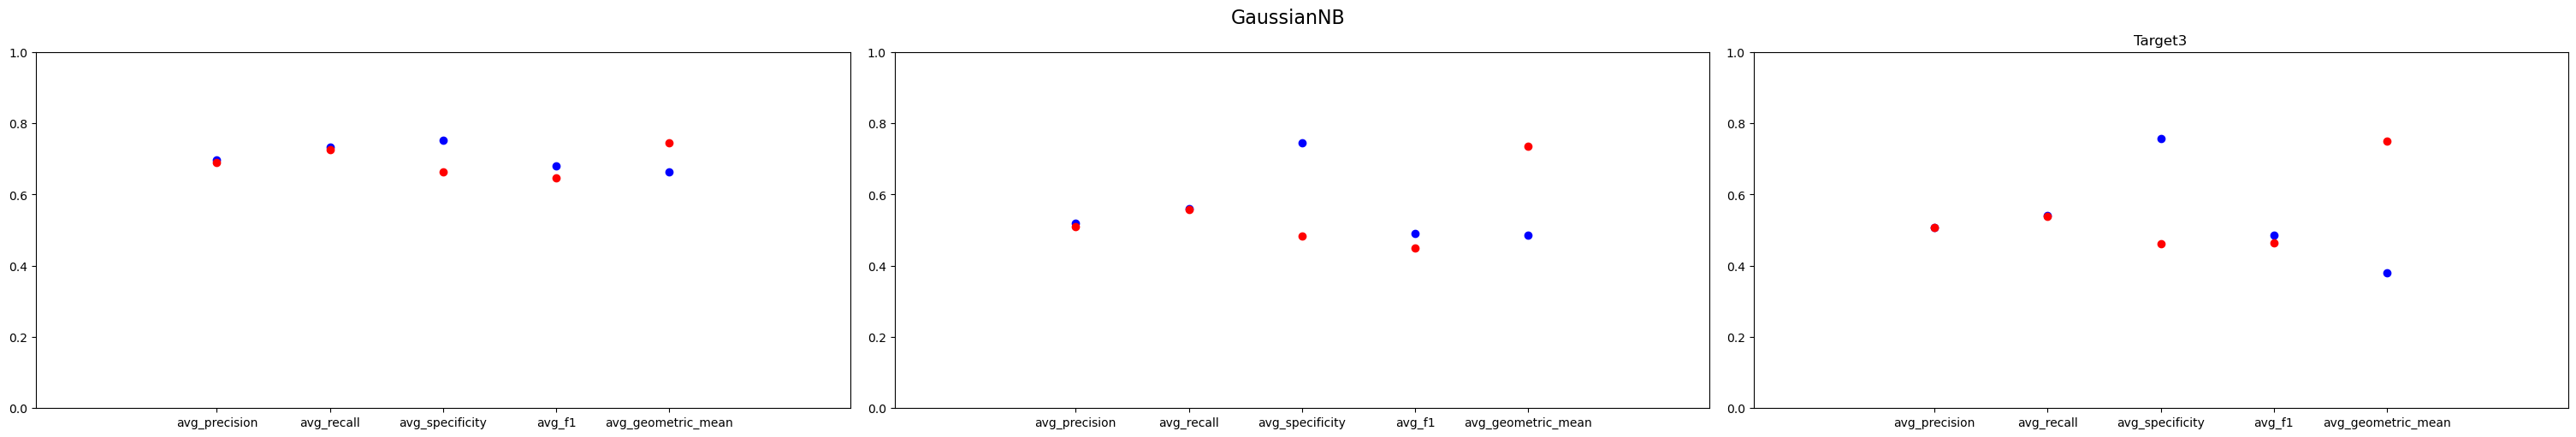

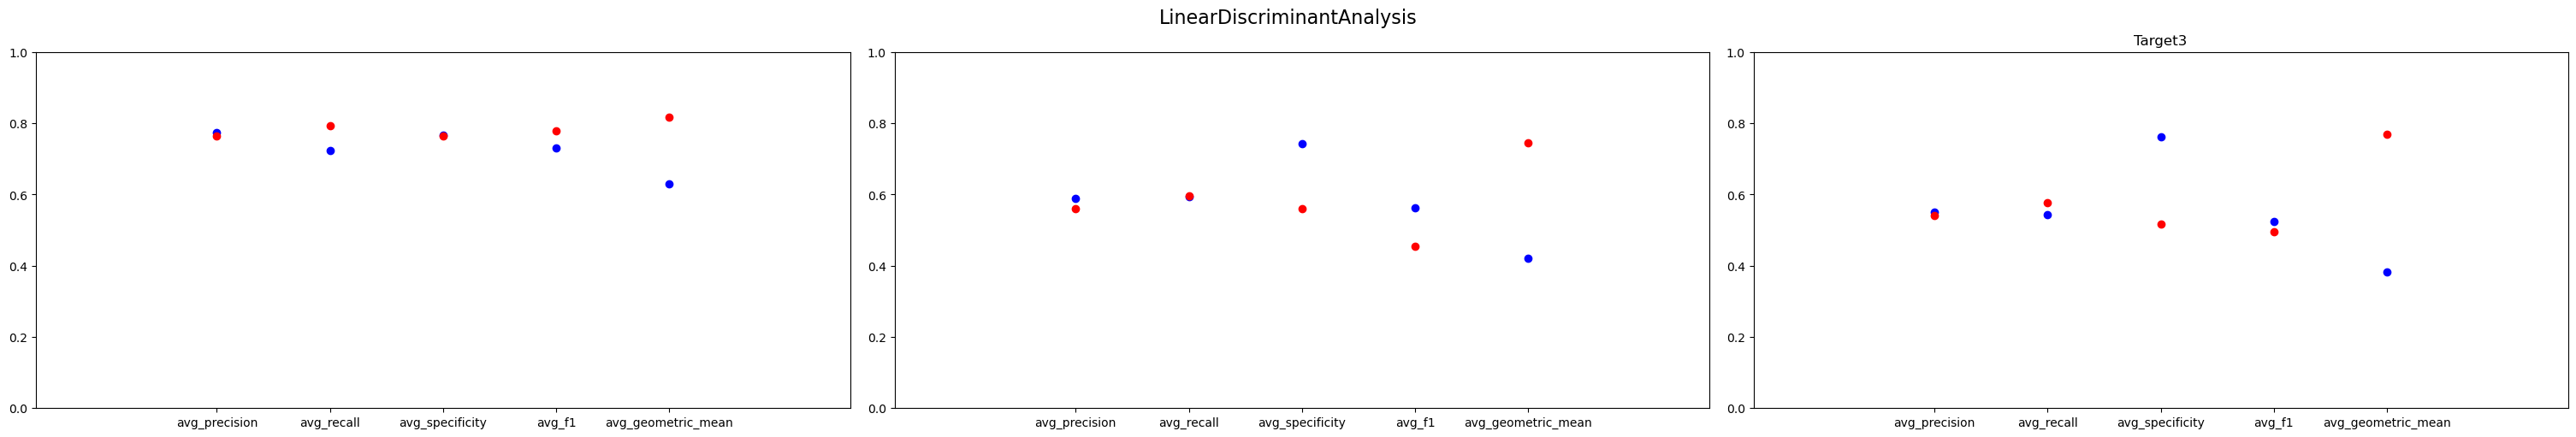

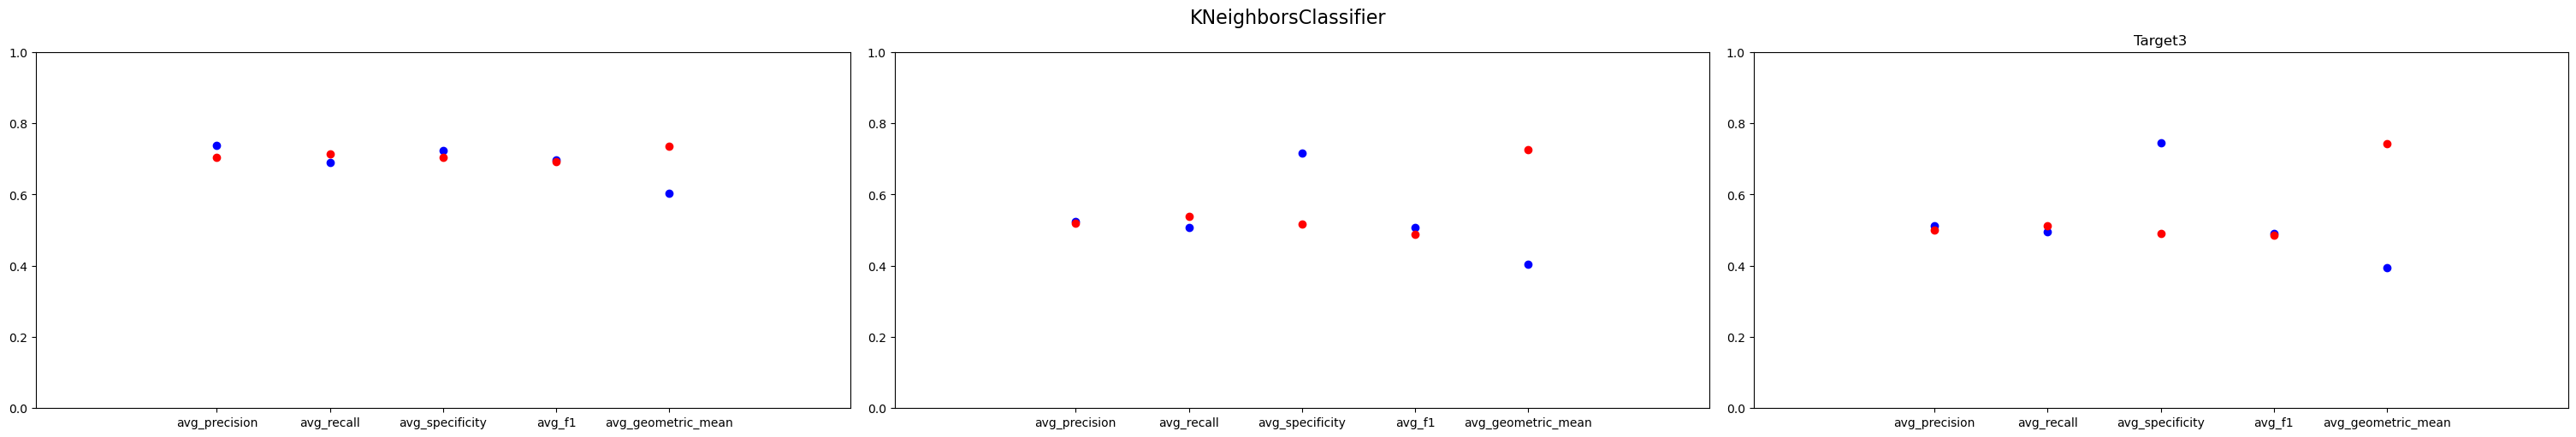

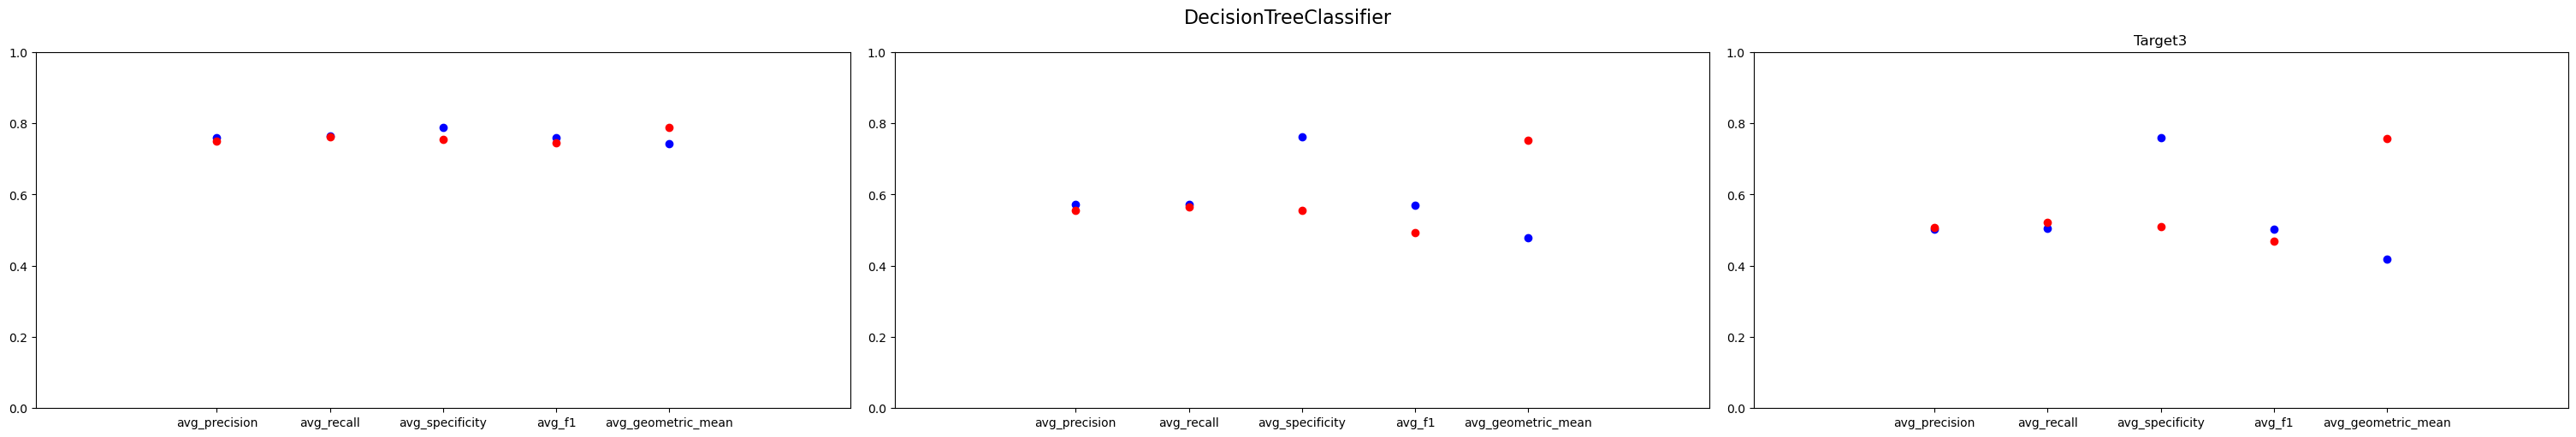

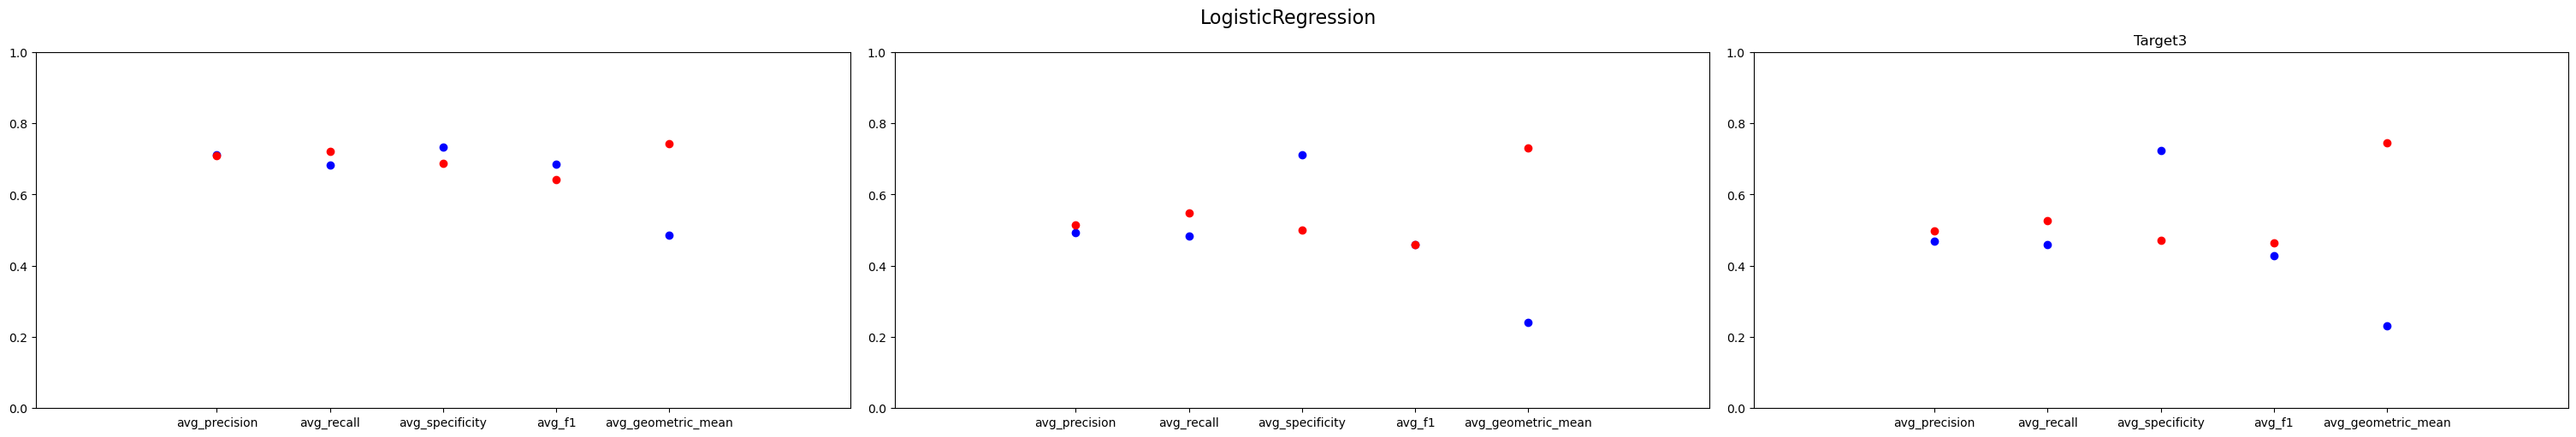

In [41]:
plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for i in range(len(learners)):
  learner = learners[i]
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  t1= aggregateMetrics[learner].iloc[0].values
  t1StandardDev = aggregateStandardDev[learner].iloc[0].values

  t1Adjusted = aggregateMetricsAdjusted[learner].iloc[0].values
  t1AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[0].values

  t2= aggregateMetrics[learner].iloc[1].values
  t2Adjusted = aggregateMetricsAdjusted[learner].iloc[1].values

  t2StandardDev = aggregateStandardDev[learner].iloc[1].values
  t2AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[1].values

  t3= aggregateMetrics[learner].iloc[2].values
  t3Adjusted = aggregateMetricsAdjusted[learner].iloc[2].values

  t3StandardDev = aggregateStandardDev[learner].iloc[2].values
  t3AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[2].values

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=16)
  fig.set_figwidth(30)
  fig.set_figheight(5)
  axs[0].set(xmargin= 0.4, ylim=(0, 1))
  axs[0].errorbar(metrics, t1, fmt='bo', linewidth=2, capsize=6)
  axs[0].errorbar(metrics, t1Adjusted ,fmt='ro', linewidth=2, capsize=6)

  plt.title('Target1')

  axs[1].set(xmargin= 0.4, ylim=(0, 1))
  axs[1].errorbar(metrics, t2, fmt='bo', linewidth=2, capsize=6)
  axs[1].errorbar(metrics, t2Adjusted, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target2')

  axs[2].set(xmargin= 0.4, ylim=(0, 1))
  axs[2].errorbar(metrics, t3, fmt='bo', linewidth=2, capsize=6)
  axs[2].errorbar(metrics, t3Adjusted, fmt='ro', linewidth=2, capsize=6)

  plt.title('Target3')

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)  
plt.show()

# print('-------------------------------')

<Figure size 2500x2500 with 0 Axes>

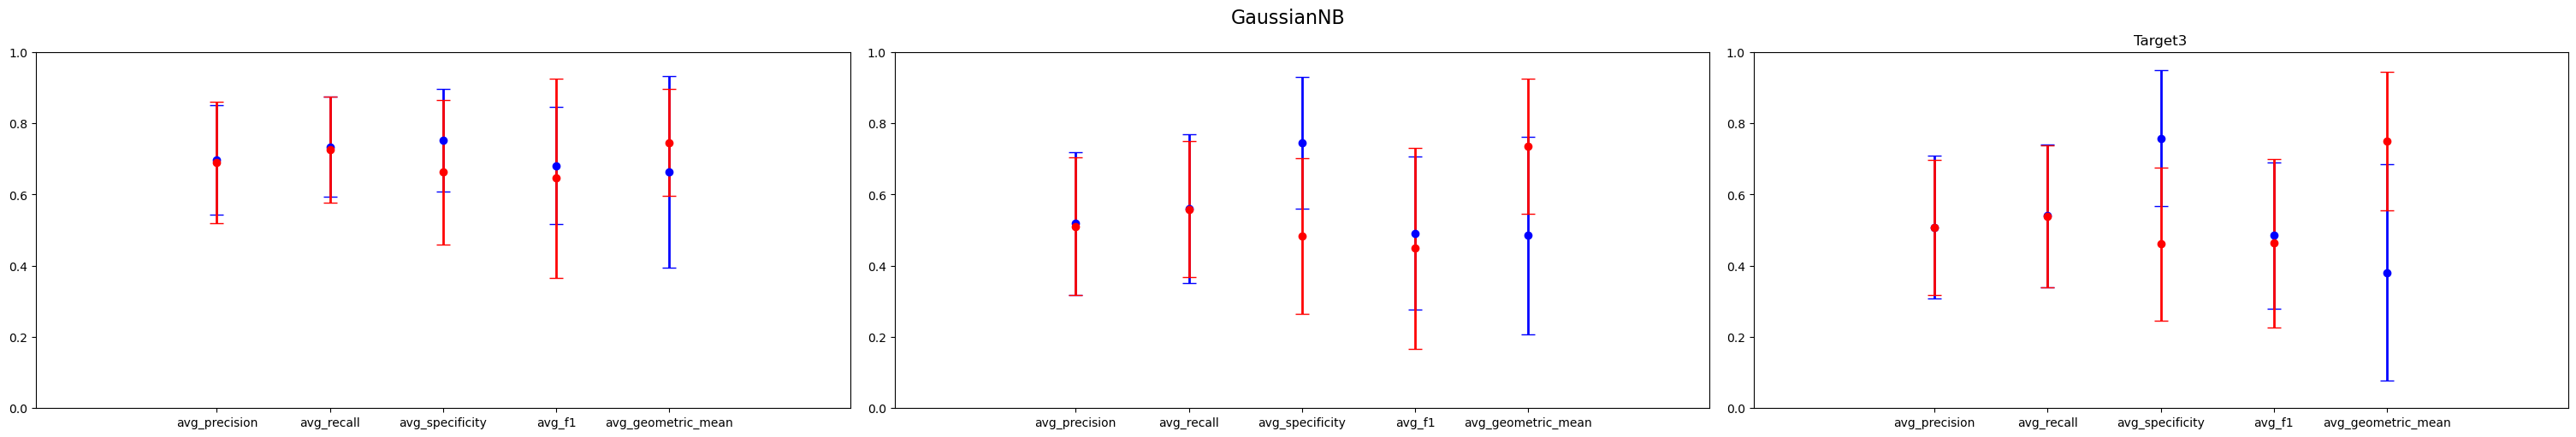

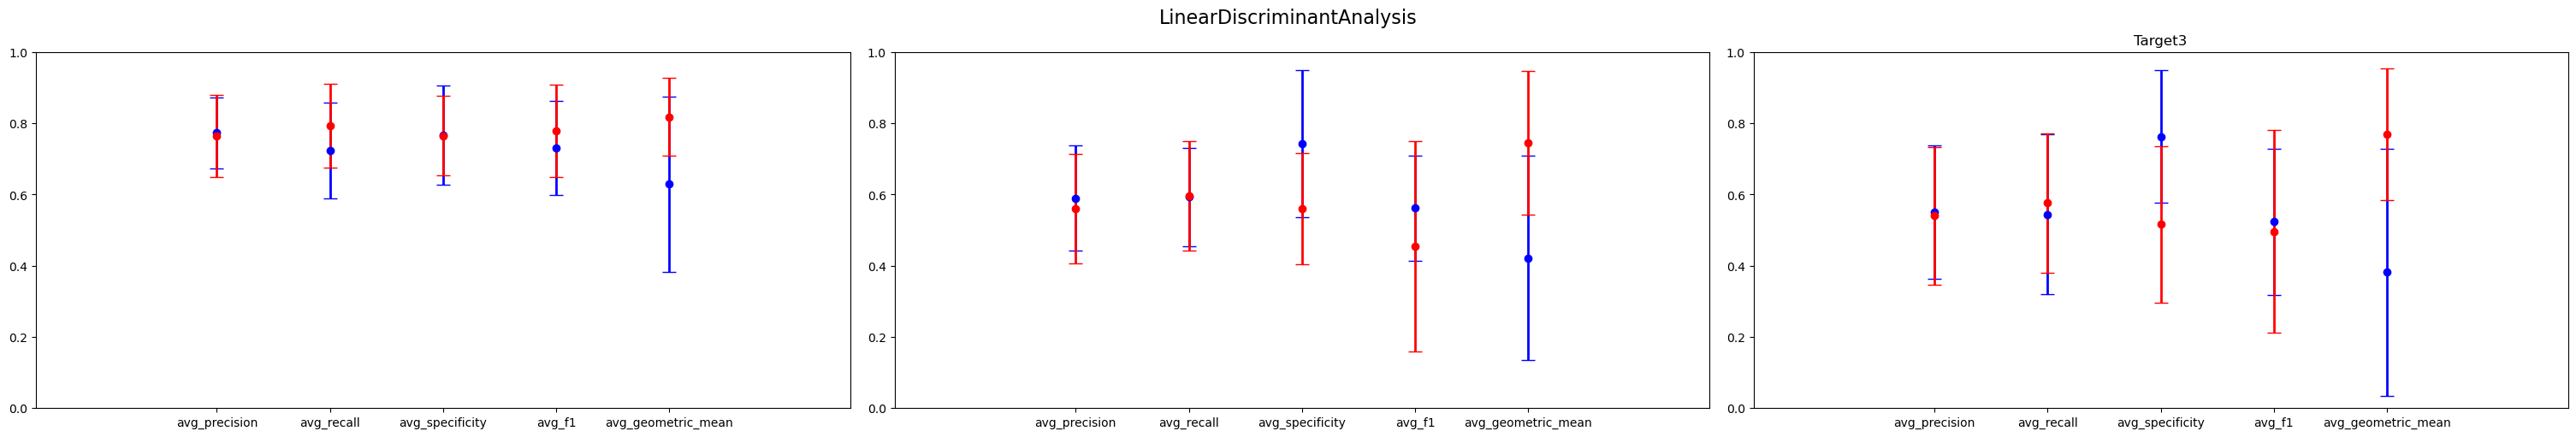

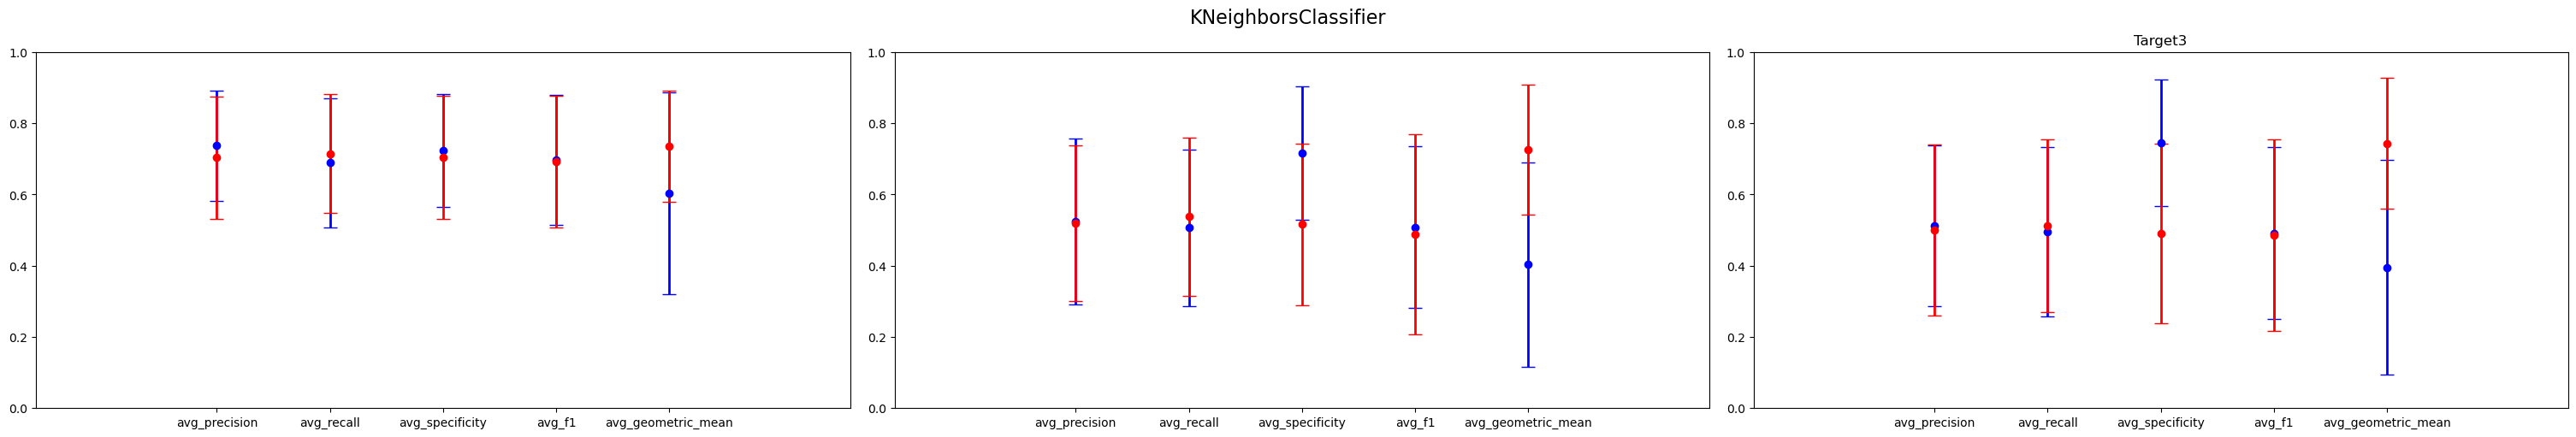

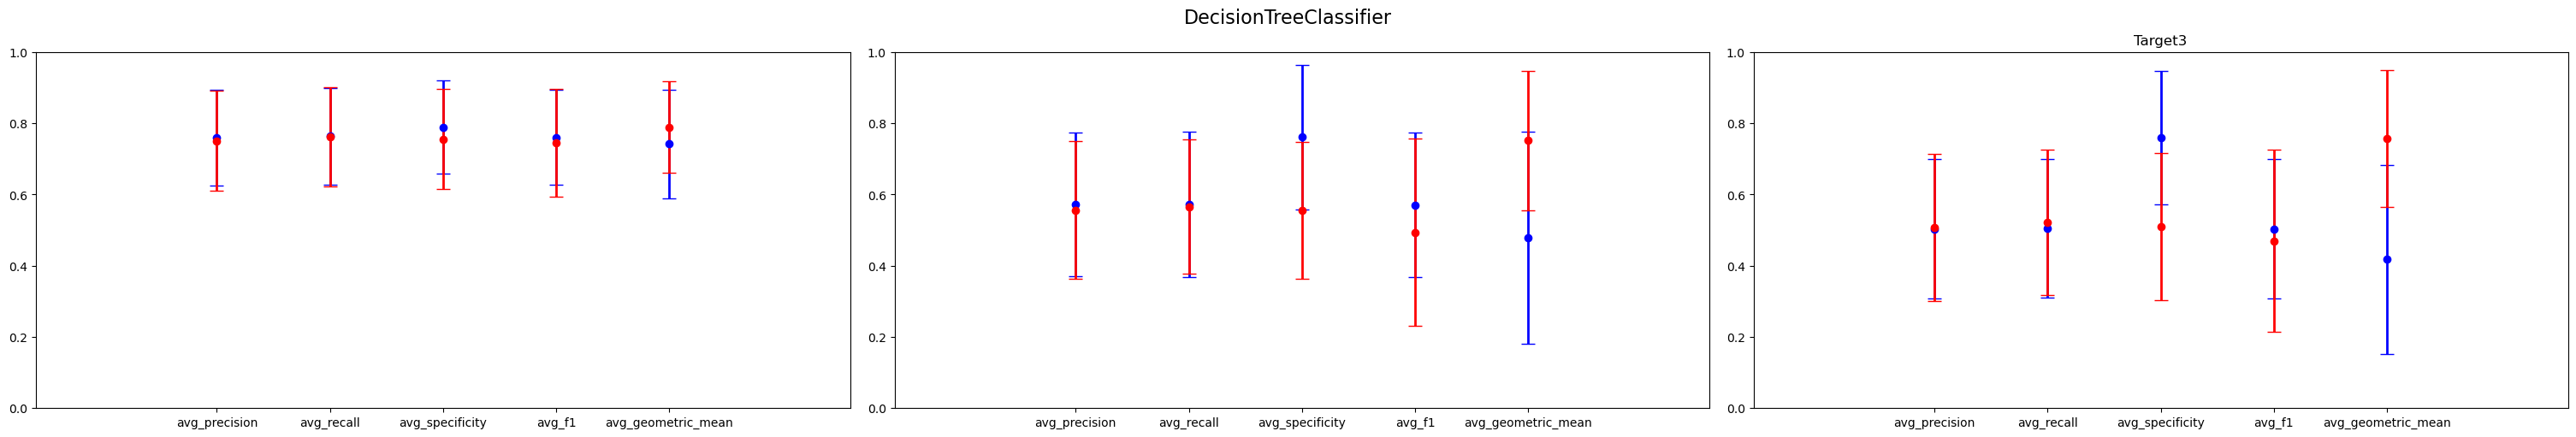

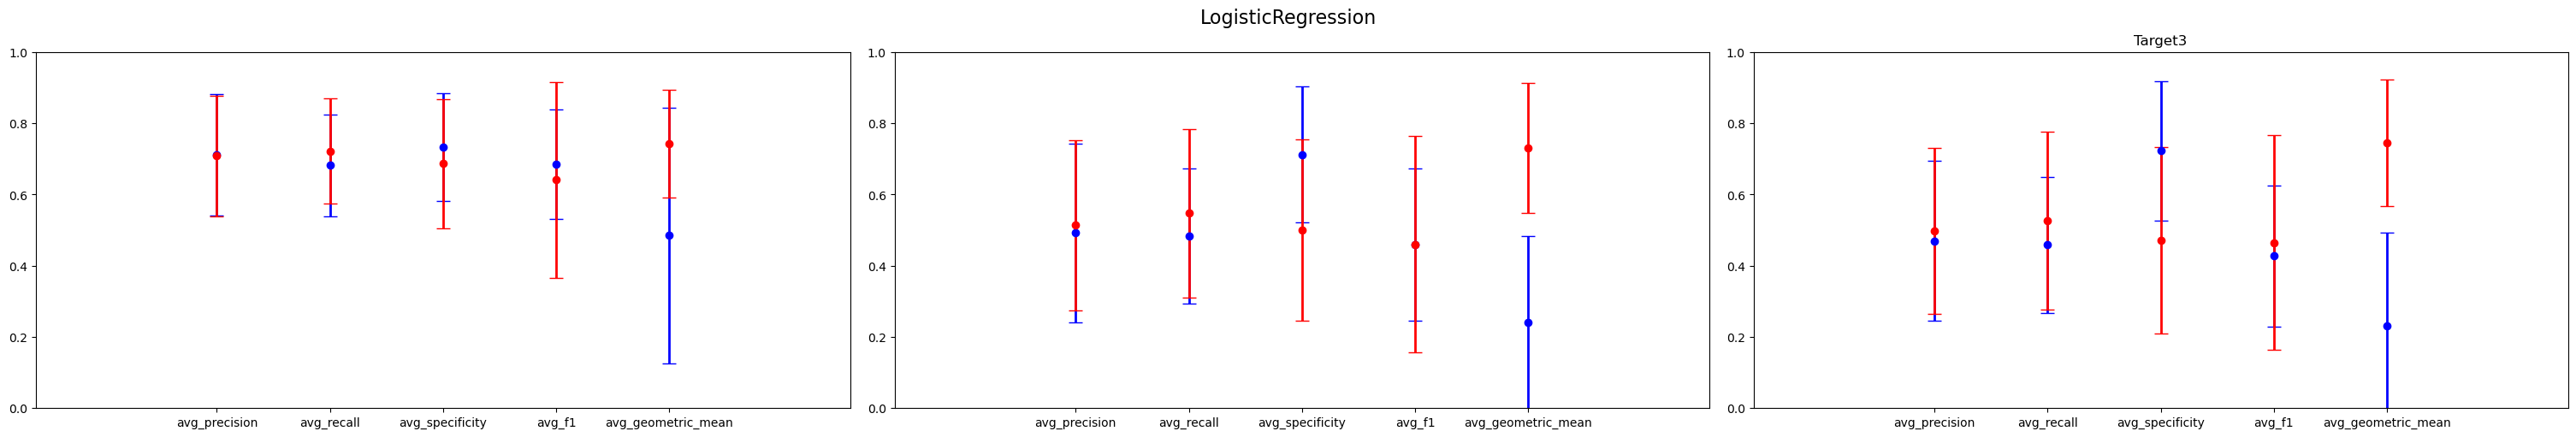

In [39]:
plt.figure(figsize=(25, 25), dpi=100)
learners = list(aggregateMetrics.keys())
for i in range(len(learners)):
  learner = learners[i]
  metrics = ['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']

  t1= aggregateMetrics[learner].iloc[0].values
  t1StandardDev = aggregateStandardDev[learner].iloc[0].values

  t1Adjusted = aggregateMetricsAdjusted[learner].iloc[0].values
  t1AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[0].values

  t2= aggregateMetrics[learner].iloc[1].values
  t2Adjusted = aggregateMetricsAdjusted[learner].iloc[1].values

  t2StandardDev = aggregateStandardDev[learner].iloc[1].values
  t2AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[1].values

  t3= aggregateMetrics[learner].iloc[2].values
  t3Adjusted = aggregateMetricsAdjusted[learner].iloc[2].values

  t3StandardDev = aggregateStandardDev[learner].iloc[2].values
  t3AdjustedStandardDev = aggregateStandardDevAdjusted[learner].iloc[2].values

  fig, axs = plt.subplots(1, 3, constrained_layout=True)
  fig.suptitle(learner, fontsize=16)
  fig.set_figwidth(30)
  fig.set_figheight(5)
  axs[0].set(xmargin= 0.4, ylim=(0, 1))
  axs[0].errorbar(metrics, t1, yerr=t1StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[0].errorbar(metrics, t1Adjusted, yerr=t1AdjustedStandardDev ,fmt='ro', linewidth=2, capsize=6)

  plt.title('Target1')

  axs[1].set(xmargin= 0.4, ylim=(0, 1))
  axs[1].errorbar(metrics, t2, yerr=t2StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[1].errorbar(metrics, t2Adjusted, yerr=t2AdjustedStandardDev, fmt='ro', linewidth=2, capsize=6)
  plt.title('Target2')

  axs[2].set(xmargin= 0.4, ylim=(0, 1))
  axs[2].errorbar(metrics, t3, yerr=t3StandardDev, fmt='bo', linewidth=2, capsize=6)
  axs[2].errorbar(metrics, t3Adjusted, yerr=t3AdjustedStandardDev, fmt='ro', linewidth=2, capsize=6)

  plt.title('Target3')

plt.subplots_adjust(left=0.0,
                    bottom=0.0,
                    right=1,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)  
plt.show()


 - Improve Presentation
   - Legend
   - Readability (blue, red, green ....) bars side by side for each metric

 - Add third bar
   - https://metallic.pythonanywhere.com/
   - Do for F1, G-mean